# **Exploratory Data Analysis**

## **Table of contents**

* [Our goals](#Our-goals)
* [What is the data?](#What-is-the-data?)
* [Vision for deployment](#Vision-for-deployment)
* [General EDA](#General-EDA)
    * [Missing values](#Missing-values)
    * [Duplicates](#Duplicates)
    * [News length](#News-length)
    * [Word cloud](#Word-cloud)
    * [News topics](#News-topics)
    * [News timeline](#News-timeline)
    * [Dataset merging and splitting](#Dataset-merging-and-splitting)
    * [General EDA summary](#General-EDA-summary)
* [Features extraction and Heuristic model](#Features-extraction-and-Heuristic-model)
    * [Features extraction](#Features-extraction)
    * [Mutual information](#Mutual-information)
    * [Heuristic model](#Heuristic-model)
    * [TF-IDF](#TF-IDF)
    * [Final heuristic model](#Final-heuristic-model)
    * [Strategy for a more generalizable model](#Strategy-for-a-more-generalizable-model)
        * [Patterns with high predictive power](#Patterns-with-high-predictive-power)
        * [Anonymization and cleaning](#Anonymization-and-cleaning)
* [Conclusion](#Conclusion)

In [1]:
import sys
import os
from pathlib import Path

project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    plot_utilities, 
    stat_utilities,
    preprocessing_utilities,
    heuristic_utilities
)
from utilities.plot_utilities import (
    Rstyle_spines,
    simple_colormap,
    multicolumn_barplot,
    plot_ngram_distribution
)
from utilities.stat_utilities import (
    extract_outliers_IQR
)

from utilities.preprocessing_utilities import (
    parallel_process,
    process_text_spacy,
    nltk_clean_text,
    nltk_count_word,
    extract_empty_short_text,
    remove_location_line,
    parse_date,
    find_most_common_words,
    extract_all_features,
    get_df_from_sparse,
    clean_final_text_batch_spacy,
    extract_ngrams
)

from utilities.heuristic_utilities import HeuristicModel
import spacy
from functools import partial
import numpy as np
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
from wordcloud import WordCloud ,STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif, chi2

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print("Cell skipped.")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/czank/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.15
NUM_WORKERS = 20
BATCH_SIZE = 32
spacy.require_cpu()
nlp = spacy.load("en_core_web_sm")

## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
In this notebook, we aim to:

* Gain a general understanding of the type of data we are working with.
* Extract linguistic, semantic, and other related features to assess their usefulness in building a fake news predictor.
* Create a general heuristic-based model that provides a quick and comprehensive way to evaluate the predictive power of a large set of features.
* Gather insights on how to develop a model that can generalize well based on our observations.
</div>

## **What is the data?**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

The first step is to load the data and examine it. If you downloaded it using this [link](#https://drive.google.com/file/d/1CZzfZDvE5E7HaHjk9yeyZDKil4_jkass/view?usp=drive_link), you should find it in the `../DS44x` directory. The dataset contains two CSV files: one with fake news and the other with true news. Let's gather some quick intel about it.  
</div>

In [3]:
true_news = pd.read_csv("../data/True.csv")
fake_news = pd.read_csv("../data/Fake.csv")

In [4]:
true_news.head(5)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [5]:
true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [6]:
fake_news.head(5)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [7]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

We have two dataframes, each containing more than 20,000 rows—one for true news and the other for fake news. Each dataframe consists of four columns: the news title, its main body text, its subject, and its publication date.

How will we use these features? The title and main text will be the key components for building our classifiers, so we will exclude both the date and subject from the model. However, we will later visualize these features to gather more insights about the data collection.

</div>

## **Vision for deployment**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
It's already time to start thinking about what our fake news detector app should look like. This will help us design the future components of our data pipeline accordingly.

Looking at our app's structure, we aim to create a simple, user-friendly prediction tool. The user will only need to input the title and body text of the news they want to verify, and the app will provide a prediction.
<p align="center">
  <img src="../figs/app_scheme.png" alt="Fake news detector app structure"/>
</p>
</div>

## **General EDA**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
It is now time to conduct a comprehensive exploratory data analysis (EDA). We will continue exploring the data, gathering as much information as possible, and cleaning it along the way whenever necessary.
</div>

### **Missing values**

In [8]:
true_news.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [9]:
fake_news.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
No explicit missing values were found in the dataset.
</div>

### **Duplicates**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
Now, we will check for duplicates by examining only the `text` feature. If two rows have the same body text, they are considered duplicates, and we should remove one of them.
</div>

In [10]:
true_news[true_news.duplicated(subset=['text'], keep='first')].head(5)

title  \
166  Factbox: What is in the U.S. Republicans' fina...   
250  Aide tries to refocus U.S. tax debate after Tr...   
445  Senate tax bill stalls on deficit-focused 'tri...   
778  Trump warns 'rogue regime' North Korea of grav...   
892  Republicans unveil tax cut bill, but the hard ...   

                                                  text       subject  \
166  (Reuters) - Republicans in the U.S. Congress r...  politicsNews   
250  WASHINGTON (Reuters) - President Donald Trump’...  politicsNews   
445  WASHINGTON (Reuters) - The U.S. Senate on Thur...  politicsNews   
778  BEIJING (Reuters) - U.S. President Donald Trum...  politicsNews   
892  WASHINGTON (Reuters) - U.S. House of Represent...  politicsNews   

                   date  
166  December 14, 2017   
250   December 7, 2017   
445  November 30, 2017   
778   November 8, 2017   
892   November 2, 2017

In [11]:
true_news[true_news.duplicated(subset=['text'], keep='first')].shape[0]

225

In [12]:
fake_news[fake_news.duplicated(subset=['text'], keep='first')].head(5)

title  \
9114   WHY THIS BLUE-COLLAR DEMOCRAT STRONGHOLD Count...   
9738   LEFTIST STORE OWNER Makes Video Asking Libs To...   
9942   HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...   
11041  Joe Scarborough BERATES Mika Brzezinski Over “...   
11190  WATCH TUCKER CARLSON Scorch Sanctuary City May...   

                                                    text   subject  \
9114   AP News  The regulars amble in before dawn and...  politics   
9738   Things didn t go as well as Nicholle had hoped...  politics   
9942   No time to waste   we've got to fight with eve...  politics   
11041                                                     politics   
11190                                                     politics   

               date  
9114   Dec 27, 2017  
9738    Oct 6, 2017  
9942    Sep 9, 2017  
11041  Apr 26, 2017  
11190   Apr 6, 2017

In [13]:
fake_news[fake_news.duplicated(subset=['text'], keep='first')].shape[0]

6026

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
While we found only 225 duplicates in the `true_news` dataset, we detected more than 6,000 in the `fake_news` dataset.  

It's important to note that our method for detecting duplicates also helps eliminate any rows with an empty body text feature. Now, it's time to remove them.
</div>

In [14]:
true_news.drop_duplicates(subset=['text'], keep='first', inplace=True)
fake_news.drop_duplicates(subset=['text'], keep='first', inplace=True)

### **News length**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Since we found many empty articles in the fake news dataset, it seems like a good idea to analyze the article lengths by examining their words count.
</div>

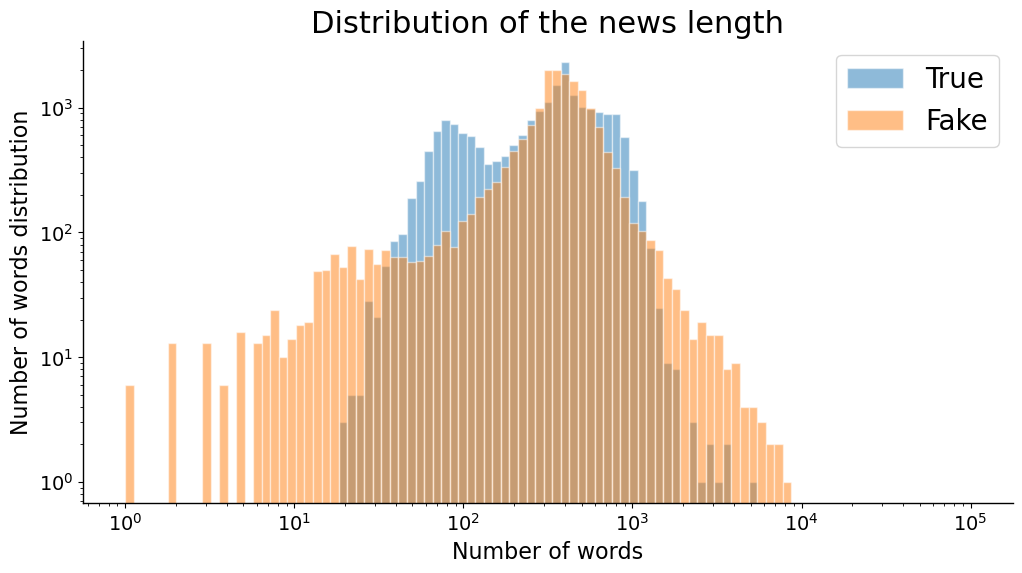

In [15]:
true_news_length = true_news["text"].apply(nltk_count_word)
fake_news_length = fake_news["text"].apply(nltk_count_word)

xmax = 100 * (max(true_news_length.max(), fake_news_length.max()) // 100 + 1)
bins=np.logspace(0, 5, num=100)
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(true_news_length, bins=bins, edgecolor="w", alpha=0.5, log=True, color="C0", label="True")
ax.hist(fake_news_length, bins=bins, edgecolor="w", alpha=0.5, log=True, color="C1", label="Fake")
ax.set_xscale("log")
ax.legend(fontsize=20)
ax.set_xlabel("Number of words", fontsize=16)
ax.set_ylabel("Number of words distribution", fontsize=16)
ax.set_title("Distribution of the news length", fontsize=22)
ax.tick_params(axis="both", labelsize=14)
Rstyle_spines(ax, lw=1)

In [16]:
short_true_news = extract_empty_short_text(true_news, min_length=25)
short_true_news.head(10)

title  \
502   Trump to make remarks at White House at 3 p.m....   
1938  Huntington Ingalls wins $2.8 billion U.S. defe...   
4544  Lockheed Martin wins $582 million U.S. defense...   
4561  Lockheed Martin wins $1.6 billion U.S. defense...   
5761  Factbox: Trump on Twitter (Feb 1) - Rex Tiller...   
6026  Factbox: Trump on Twitter (Jan 25) - ABC inter...   
6131  White House: Trump speaks with Egypt's Sisi by...   
6184  Factbox: Trump on Twitter (Jan 19)-Rev. Graham...   
6597  Putin says wants constructive relations with T...   
8154  Democratic VP nominee Kaine expected to releas...   

                                                   text       subject  \
502   WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
1938  WASHINGTON (Reuters) - Huntington Ingalls Inc ...  politicsNews   
4544  WASHINGTON (Reuters) - Lockheed Martin Corp is...  politicsNews   
4561  WASHINGTON (Reuters) - Lockheed Martin Corp wa...  politicsNews   
5761  The following bullet points are from the U.S. ...  politicsNews   
6026  The following bullet points are from the U.S. ...  politicsNews   
6131  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
6184  The following bullet points are from the U.S. ...  politicsNews   
6597  MOSCOW (Reuters) - Russian President Vladimir ...  politicsNews   
8154  WASHINGTON (Reuters) - Democratic vice preside...  politicsNews   

                     date  
502    November 28, 2017   
1938   September 1, 2017   
4544      March 31, 2017   
4561      March 31, 2017   
5761    February 2, 2017   
6026    January 25, 2017   
6131    January 23, 2017   
6184    January 20, 2017   
6597   December 23, 2016   
8154  September 14, 2016

In [17]:
short_fake_news = extract_empty_short_text(fake_news, min_length=25)
short_fake_news.head(10)

title  \
9358   https://100percentfedup.com/served-roy-moore-v...   
10923  TAKE OUR POLL: Who Do You Think President Trum...   
11117  MY FAVORITE EXCUSES…Featuring Hillary Rotten C...   
11222  FOX NEWS REPORTER Busts Spying On Trump Wide O...   
11233  JUDGE JEANINE’S OPENING STATEMENT: “Our Presid...   
11240  BUSTED! CLINTON ADVISOR JOHN PODESTA Paid BIG ...   
11251  MELANIA TRUMP GIVES POWERFUL SPEECH to Honor ‘...   
11278  KELLYANNE CONWAY: Here’s My Favorite SNL Skit!...   
11286  TERRORISM EXPERT SEBASTIAN GORKA On What Next ...   
11288  TRUMP CABINET MEMBER MICK MULVANEY ON DC: “Thi...   

                                                    text   subject  \
9358   https://100percentfedup.com/served-roy-moore-v...  politics   
10923                                                     politics   
11117                                             Enjoy:  politics   
11222  FOX NEWS ALERT: New details on @adamhousley s ...  politics   
11233  Watch my #OpeningStatment   pic.twitter.com/Qp...  politics   
11240  Russia gave John Podesta 35 millions dollars (...  politics   
11251        https://www.youtube.com/watch?v=cJZFepSvxzM  politics   
11278  We have to agree that this one is actually pre...  politics   
11286        https://www.youtube.com/watch?v=-7Tn4gi_Os8  politics   
11288  https://www.youtube.com/watch?time_continue=2&...  politics   

                                                    date  
9358   https://100percentfedup.com/served-roy-moore-v...  
10923                                       May 10, 2017  
11117                                       Apr 17, 2017  
11222                                        Apr 3, 2017  
11233                                        Apr 1, 2017  
11240                                        Apr 1, 2017  
11251                                       Mar 30, 2017  
11278                                       Mar 27, 2017  
11286                                       Mar 26, 2017  
11288                                       Mar 26, 2017

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
From the graph above, it is clear that the fake news dataset contains a significantly higher number of very short articles—i.e., articles with fewer than 25 words As we’ve already observed through multiple glimpses of the data, this discrepancy arises from differences in the news collection process. While true news is primarily sourced from the Reuters website, many fake news entries appear to be taken directly from Twitter feeds, with some even being simple URL links.  

These extremely short "articles" are unlikely to be valuable for training a well-generalizable model. Therefore, we will remove them.
</div>

In [18]:
true_news.drop(short_true_news.index, inplace=True)
fake_news.drop(short_fake_news.index, inplace=True)

### **WordCloud**

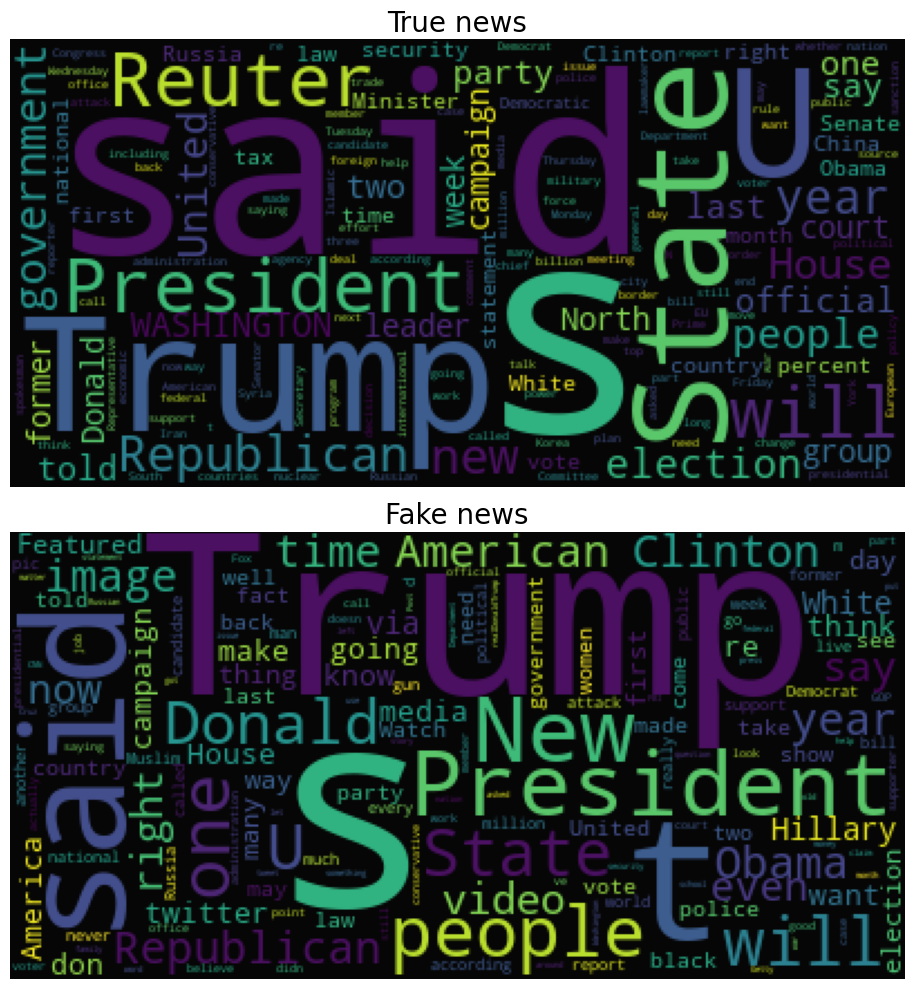

In [19]:
stopword=set(STOPWORDS)

fig, axs = plt.subplots(2, 1, figsize=(12, 10))

text = true_news["title"] + " " + true_news["text"]
wc= WordCloud(background_color='black',
              max_words=200,
              stopwords=stopword,
              collocations=False)
wc.generate(' '.join(text))
axs[0].imshow(wc.recolor(colormap='viridis' , random_state=RANDOM_STATE), alpha=0.98)
axs[0].axis("off")
axs[0].set_title("True news", fontsize=20)

text = fake_news["title"] + " " + fake_news["text"]
wc= WordCloud(background_color='black',
              max_words=200,
              stopwords=stopword,
              collocations=False)
wc.generate(' '.join(text))
axs[1].imshow(wc.recolor(colormap='viridis' , random_state=RANDOM_STATE), alpha=0.98)
axs[1].axis("off")
axs[1].set_title("Fake news", fontsize=20)

plt.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
From the word cloud above, we can observe that some words appear frequently in both the true and fake news datasets. These datasets were collected in 2016 and 2017, around the time of the primaries, the US election, and Donald Trump’s rise to success. Given the American focus, it makes sense that words like "Donald Trump," "Hillary Clinton," and "Obama" would appear often.  

Additionally, in the true news dataset, the word "Reuters" appears frequently. This is due to the news format, where the location line "CITY (Reuters)" appears at the beginning of almost every article. This could be problematic because if we train a model on this dataset, it might easily distinguish between fake and true news by relying on this pattern, but it would poorly generalize. Furthermore, someone could easily bypass detection by adding a similar location line at the beginning of a fake news article.
</div>

In [20]:
true_news["text"] = true_news["text"].apply(remove_location_line)
fake_news["text"] = fake_news["text"].apply(remove_location_line)
true_news.head(5)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  The head of a conservative Republican faction ...  politicsNews   
1  Transgender people will be allowed for the fir...  politicsNews   
2  The special counsel investigation of links bet...  politicsNews   
3  Trump campaign adviser George Papadopoulos tol...  politicsNews   
4  President Donald Trump called on the U.S. Post...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

### **News topics**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Both datasets include information about the topic of the news. Based on what we've observed, most of the news appears to be centered around American politics. However, let's take a closer look at what this feature suggests.
</div>

Text(0.5, 1.0, 'Fake news subject count')

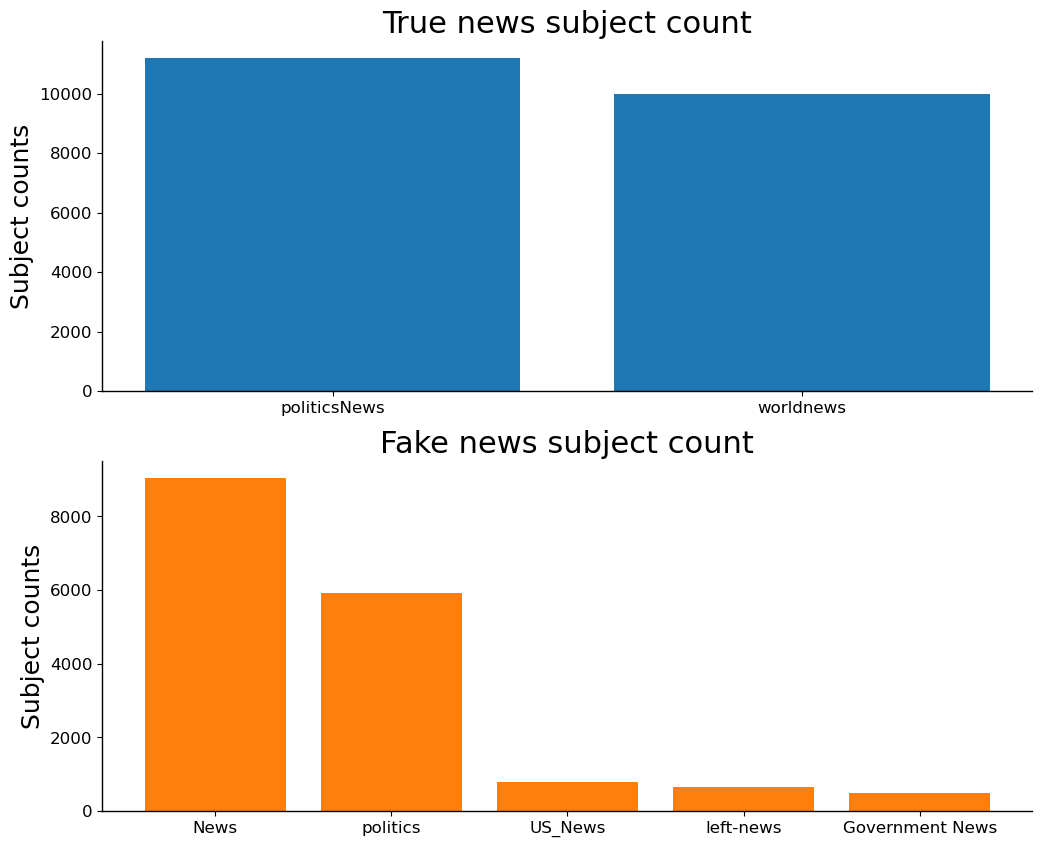

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].bar(true_news["subject"].value_counts().index, true_news["subject"].value_counts().values)
axs[0].set_ylabel("Subject counts", fontsize=18)
axs[0].tick_params(axis="both", labelsize=12)
Rstyle_spines(axs[0], lw=1)
axs[0].set_title("True news subject count", fontsize=22)
axs[1].bar(fake_news["subject"].value_counts().index, fake_news["subject"].value_counts().values, color="C1")
axs[1].set_ylabel("Subject counts", fontsize=18)
axs[1].tick_params(axis="both", labelsize=12)
Rstyle_spines(axs[1], lw=1)
axs[1].set_title("Fake news subject count", fontsize=22)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The barplot above confirms our initial assumption: the vast majority of the news articles are centered around the United States. For those that do not relate to events in the US, they tend to reflect the American public's opinion on something that occurred elsewhere in the world.
</div>

### **News timeline**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Since the publication date is provided, we will examine the news timeline across both datasets. The first step is to ensure that the date column is in a readable format.
</div>

In [22]:
true_news["date"] = true_news["date"].apply(parse_date)
fake_news["date"] = fake_news["date"].apply(parse_date)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
Before plotting the number of articles per day, we'll create a simple function that, with the help of a `CountVectorizer`, will help us identify the main topic of a given day. For instance, if we look at April 7th, 2017, we might find that some of the most frequent words were `strike`, `syrian`, `chemical`, `missile`, etc. After researching the event, we could conclude that the majority of media outlets were discussing the US's attack on the Syrian regime.  

We will use this approach to identify "extreme" events—dates with an unusually high number of published news articles.
</div>

In [23]:
count_uni = CountVectorizer(
    strip_accents='unicode',
    preprocessor=partial(process_text_spacy, nlp=nlp),
    max_features=200,
    lowercase=False,
    ngram_range=(1, 1)
)

find_most_common_words(true_news, "text", countv=count_uni, 
                       max_features=50, date=pd.to_datetime("7-Apr-17"))[:10]

say          346
trump        166
strike       148
syrian       145
syria        125
president    123
attack       122
chemical      92
missile       87
military      85
dtype: int64

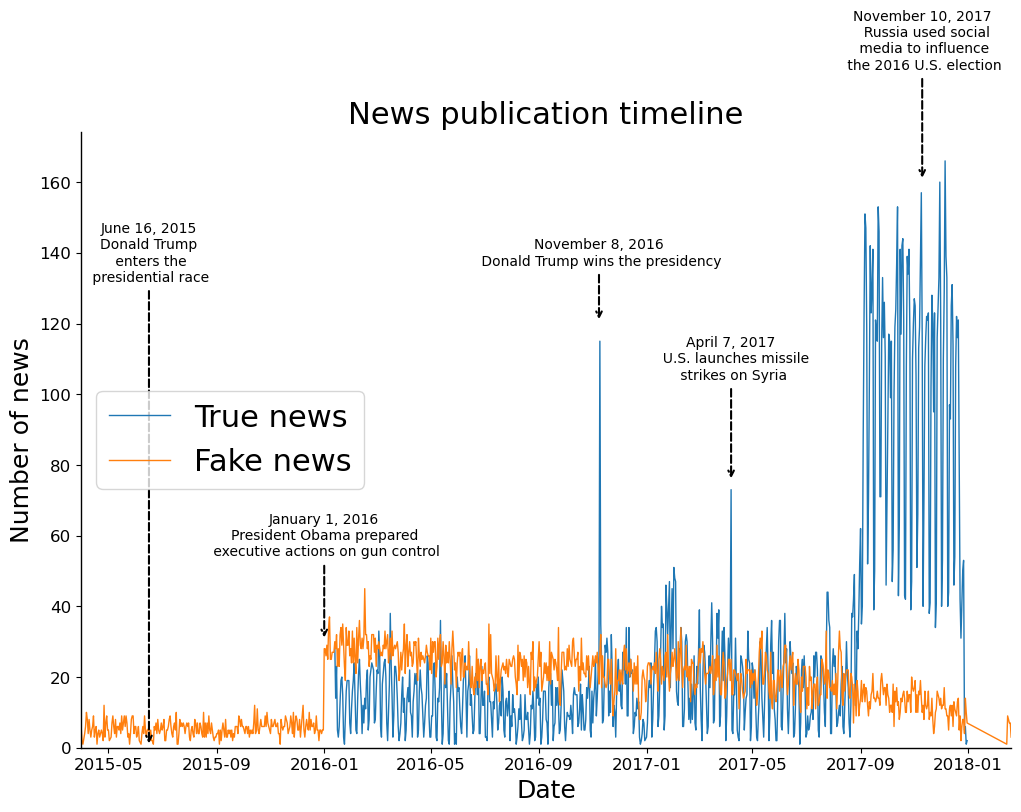

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

true_news_count = true_news.groupby("date").size()
fake_news_count = fake_news.groupby("date").size()

xmin = min(fake_news_count.index.min(), true_news_count.index.min())
xmax = max(fake_news_count.index.max(), true_news_count.index.max())
ymin = min(fake_news_count.min(), true_news_count.min())

ax.plot(true_news_count.index, true_news_count.values, lw=1, color="C0", label="True news")
ax.plot(fake_news_count.index, fake_news_count.values, lw=1, color="C1", label="Fake news")

arrow_props = dict(arrowstyle='->', color='black', linestyle="--", linewidth=1.5, shrinkA=3, shrinkB=3)

ax.annotate(text="June 16, 2015\nDonald Trump\n enters the\n presidential race",
            xy=(pd.to_datetime("16-Jun-15"), 0),
            xytext=(pd.to_datetime("16-Jun-15"), 140), ha="center", va="center",
            arrowprops=arrow_props)

ax.annotate(text="January 1, 2016\nPresident Obama prepared\n executive actions on gun control",
            xy=(pd.to_datetime("1-Jan-16"), 30),
            xytext=(pd.to_datetime("1-Jan-16"), 60), ha="center", va="center",
            arrowprops=arrow_props)

ax.annotate(text="November 8, 2016\n Donald Trump wins the presidency",
            xy=(pd.to_datetime("8-Nov-16"), 120),
            xytext=(pd.to_datetime("8-Nov-16"), 140), ha="center", va="center",
            arrowprops=arrow_props)

ax.annotate(text="April 7, 2017\n  U.S. launches missile\n strikes on Syria",
            xy=(pd.to_datetime("7-Apr-17"), 75),
            xytext=(pd.to_datetime("7-Apr-17"), 110), ha="center", va="center",
            arrowprops=arrow_props)

ax.annotate(text="November 10, 2017\n  Russia used social\n media to influence\n the 2016 U.S. election",
            xy=(pd.to_datetime("10-Nov-17"), 160),
            xytext=(pd.to_datetime("10-Nov-17"), 200), ha="center", va="center",
            arrowprops=arrow_props)
ax.set_xlabel("Date", fontsize=18)
ax.set_ylabel("Number of news", fontsize=18)
ax.set_title("News publication timeline", fontsize=22)
ax.set_xlim((xmin, xmax))
ax.set_ylim(bottom=0)
ax.tick_params(axis="both", labelsize=12)
ax.legend(loc=6, fontsize=22)
Rstyle_spines(ax, lw=1)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
The news timeline reveals some interesting patterns and raises several observations:

* The collection of fake news started before `March 31st, 2015`, well before the collection of true news, which began on `January 13th, 2016`.  
* Between `January 2016` and `September 2017`, the number of fake and true news articles collected was relatively similar. However, after this period, there is a huge surge in the number of true news articles compared to fake news. Could some of these articles be backdated?  
* Finally, the dataset is very time-clustered. We had already seen from the word cloud that the news are mostly centered around American politics. Indeed, the dataset spans the period during Donald Trump’s presidential race and the early years of his presidency.  

The challenge here is that, while we’re supposed to create a fake news detector, the data we have is already very specific—focused on American politics. This raises the concern that our model might not generalize well outside this scope. We’ll need to explore ways to make the model more generalizable so that it can be applied beyond just American political news.
</div>

### **Dataset merging and splitting**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
To conclude this section, we’ll format the data in preparation for future use. Specifically, we will concatenate the title and body text into a single feature and retain only the label (true or fake). Afterward, we’ll proceed with the standard training/test split. Before that, since we've removed many rows, especially from the fake news dataset, let's get a quick look at the possible imbalance this generated.
</div>

In [25]:
true_news.shape[0], fake_news.shape[0]

(21178, 16893)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
As we can see, there are no more true news articles than fake news articles; we will therefore ensure to stratify our training/testing split accordingly.
</div>

In [26]:
true_news["label"] = 0
fake_news["label"] = 1

true_news["text"] = true_news["text"] + " " + true_news["title"]
fake_news["text"] = fake_news["text"] + " " + fake_news["title"]

all_news = (pd.concat([true_news, fake_news], ignore_index=True)
            .drop(columns=["date", "subject", "title"], axis=1)
            .sample(frac=1))

train_set, test_set = train_test_split(all_news, train_size=0.8, stratify=all_news["label"])
train_set.to_csv("../data/train_set.csv")
test_set.to_csv("../data/test_set.csv")

In [27]:
train_set = pd.read_csv("../data/train_set.csv", index_col=0)
test_set = pd.read_csv("../data/test_set.csv", index_col=0)

### **General EDA summary**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
So far, we have:

* Reviewed the data we are working with and cleaned it along the way, removing empty or very short articles, eliminating text duplicates, and addressing misshaped ones.  
* Raised several concerns about the data, such as its time and topic clustering. This could potentially hinder our model's ability to generalize. For example, scientific fake news has no representation in this dataset.  
* Additionally, while we’re not done exploring the data, we’ve observed that the true news and fake news datasets seem to be quite different in nature. Fake news articles often appear poorly written (e.g., extracted from Twitter feeds), while true news seems to be sourced from established outlets like Reuters (evidenced by the location line we had to remove).

These points will be crucial as we move forward with model development, and we’ll need to address them to improve the generalizability of our fake news detector.
</div>

## **Features extraction and Heuristic model**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
If we want a model that generalizes well, we’ll need to continue with the cleaning process. A good way to guide our cleaning efforts is to build a simple heuristic model to perform predictions and assess its performance. If the model performs too well, it could indicate that the dataset is not yet properly cleaned and might contain patterns or biases that the model is overfitting to.
</div>

### **Features extraction**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
We begin our journey by extracting as many features as possible from the raw text, which will serve as input for a classifier, or for now, a simple heuristic model. Our feature extraction function (see `preprocessing_utilities.py`) focuses on two types of features: linguistic and structural.  

For the structural features, we've utilized the powerful `spaCy` library. This helps us extract features such as the number of characters, the count of uppercase words, the number of personalities mentioned, and the number of adverbs. For the linguistic features, we've employed the `textstat` library. Some of the extracted features focus on text readability, which can help identify differences in writing quality.  

In total, extracting the 42 features for both the training and test datasets should take around 20 minutes using a GPU. Alternatively, you can download the files and place them in the local `../data/` directory.
</div>

In [28]:
train_text_first_features = parallel_process(train_set, extract_all_features, nlp=nlp, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_text_first_features = parallel_process(test_set, extract_all_features, nlp=nlp, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

/home/czank/miniconda3/envs/dl_capstone/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|███████████████████████████████████████████████████████████████| 20/20 [02:03<00:00,  6.15s/it]
/home/czank/miniconda3/envs/dl_capstone/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|███████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.66s/it]


### **Mutual information**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We have extracted a large number of features from the raw text. A quick way to get an idea of how the target feature (whether the news is fake or not) depends on the extracted features is to compute the mutual information. Of course, mutual information is a univariate measure and won't reflect the predictive power of a feature when inserted into a model. However, it can help detect possible direct correlations between the features and the target variable.
</div>

Text(0.5, 0.98, 'Text features mutual information')

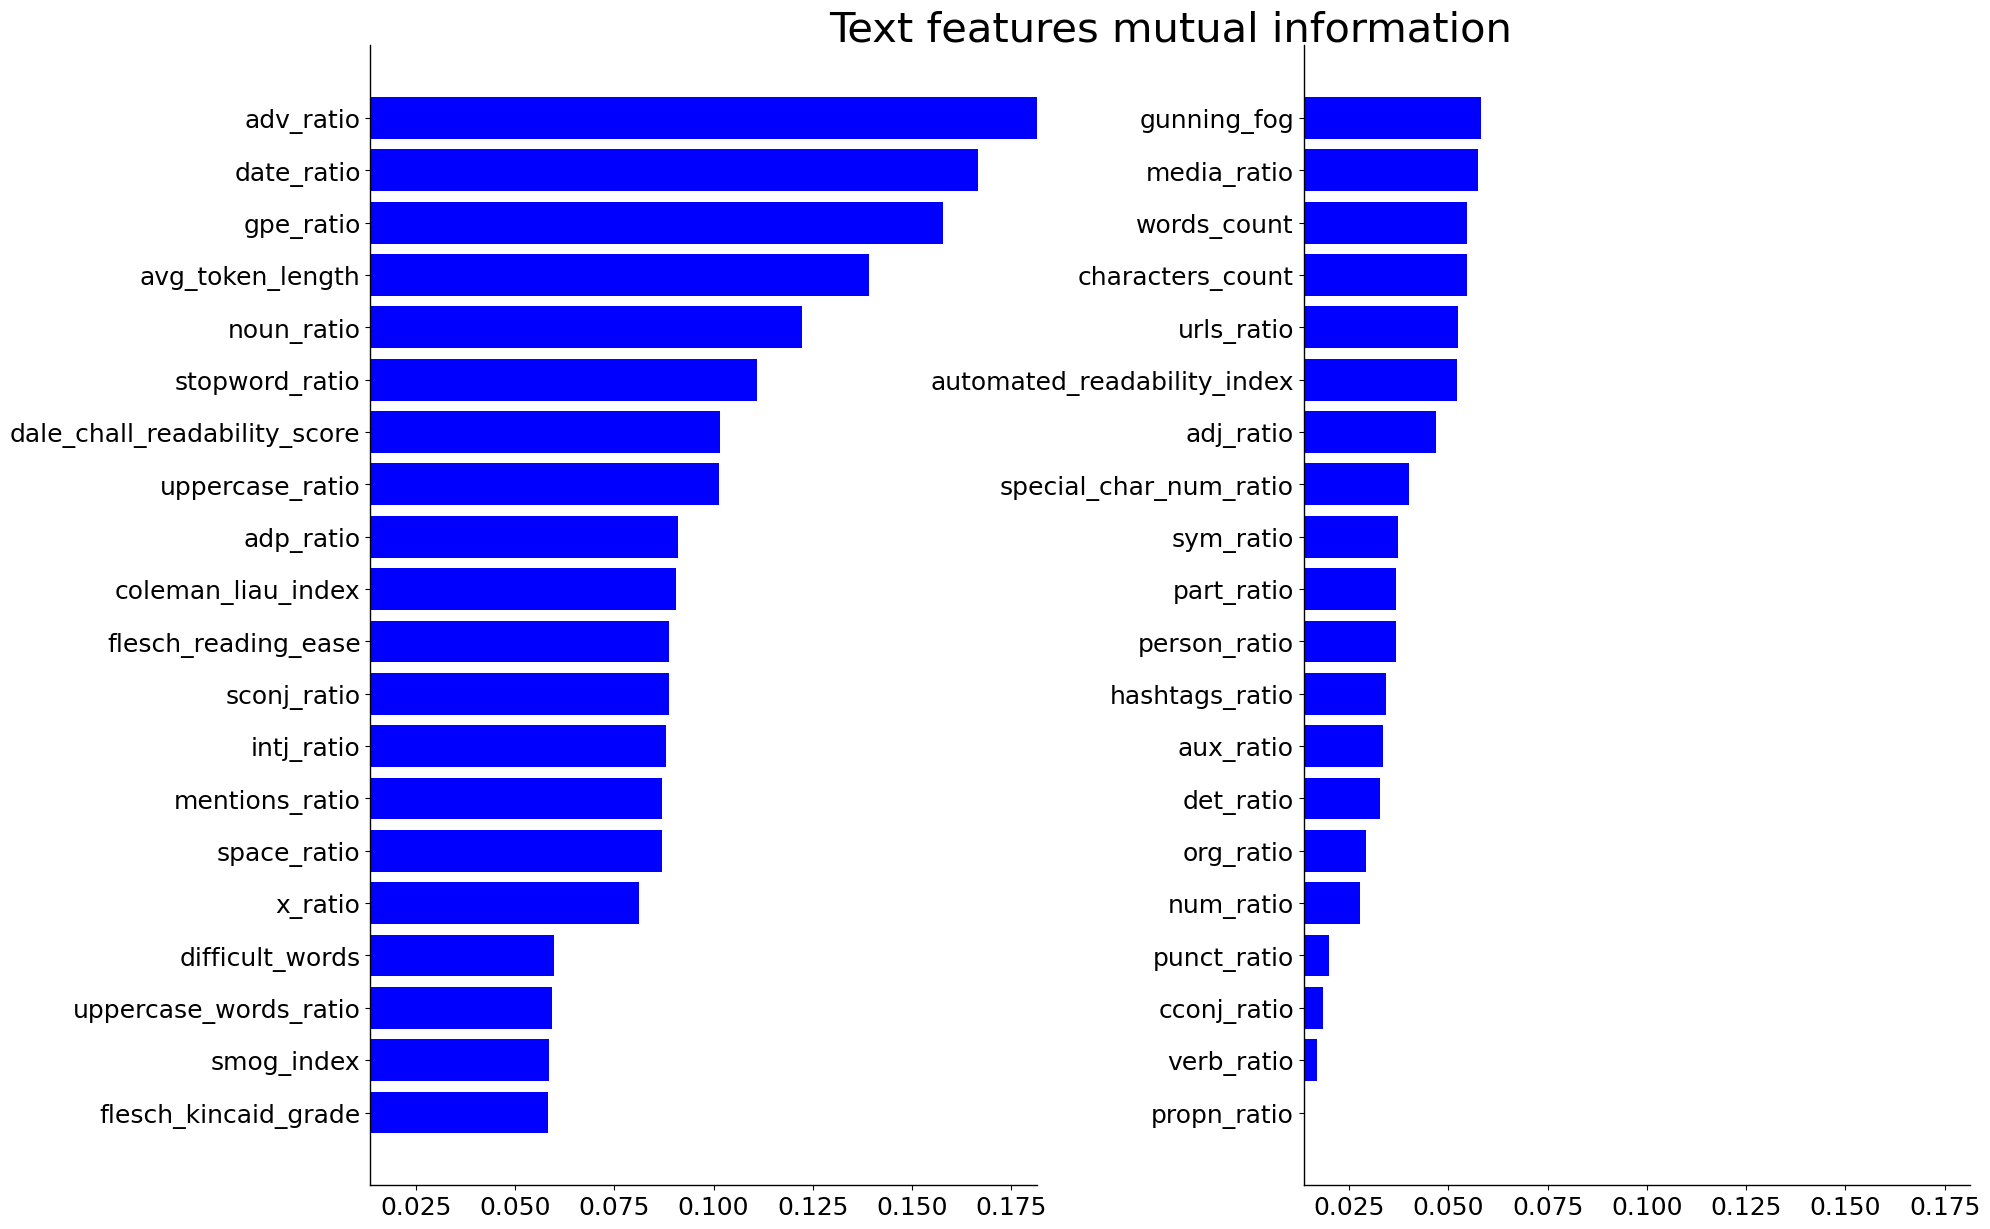

In [29]:
numeric_features = [feat for feat in train_text_first_features.select_dtypes(include=np.number).columns.tolist() 
                    if feat != "label"]
mi_score = mutual_info_classif(train_text_first_features[numeric_features], 
                               train_text_first_features["label"])
mis = {feat: mi for feat, mi in zip(numeric_features, mi_score)}
sorted_mis = {k: v for k, v in sorted(mis.items(), key=lambda item: item[1], reverse=True)}
mis_df = pd.DataFrame(list(sorted_mis.items()), columns=['Feature', 'Value'])

fig = plt.figure(figsize=(16, 12))
axs = multicolumn_barplot(
    mis_df, fig, y="Feature", width="Value", tick_fs=18
)
fig.suptitle("Text features mutual information", fontsize=30)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
From what we see above, it appears that the adverb count, the date, and the GPE (geopolitical entity) ratio are the top three predictors. These are followed by the average token length and the interjection ratio. Let's visualize these features to get a better understanding of their distributions and relationships with the target variable!
</div>

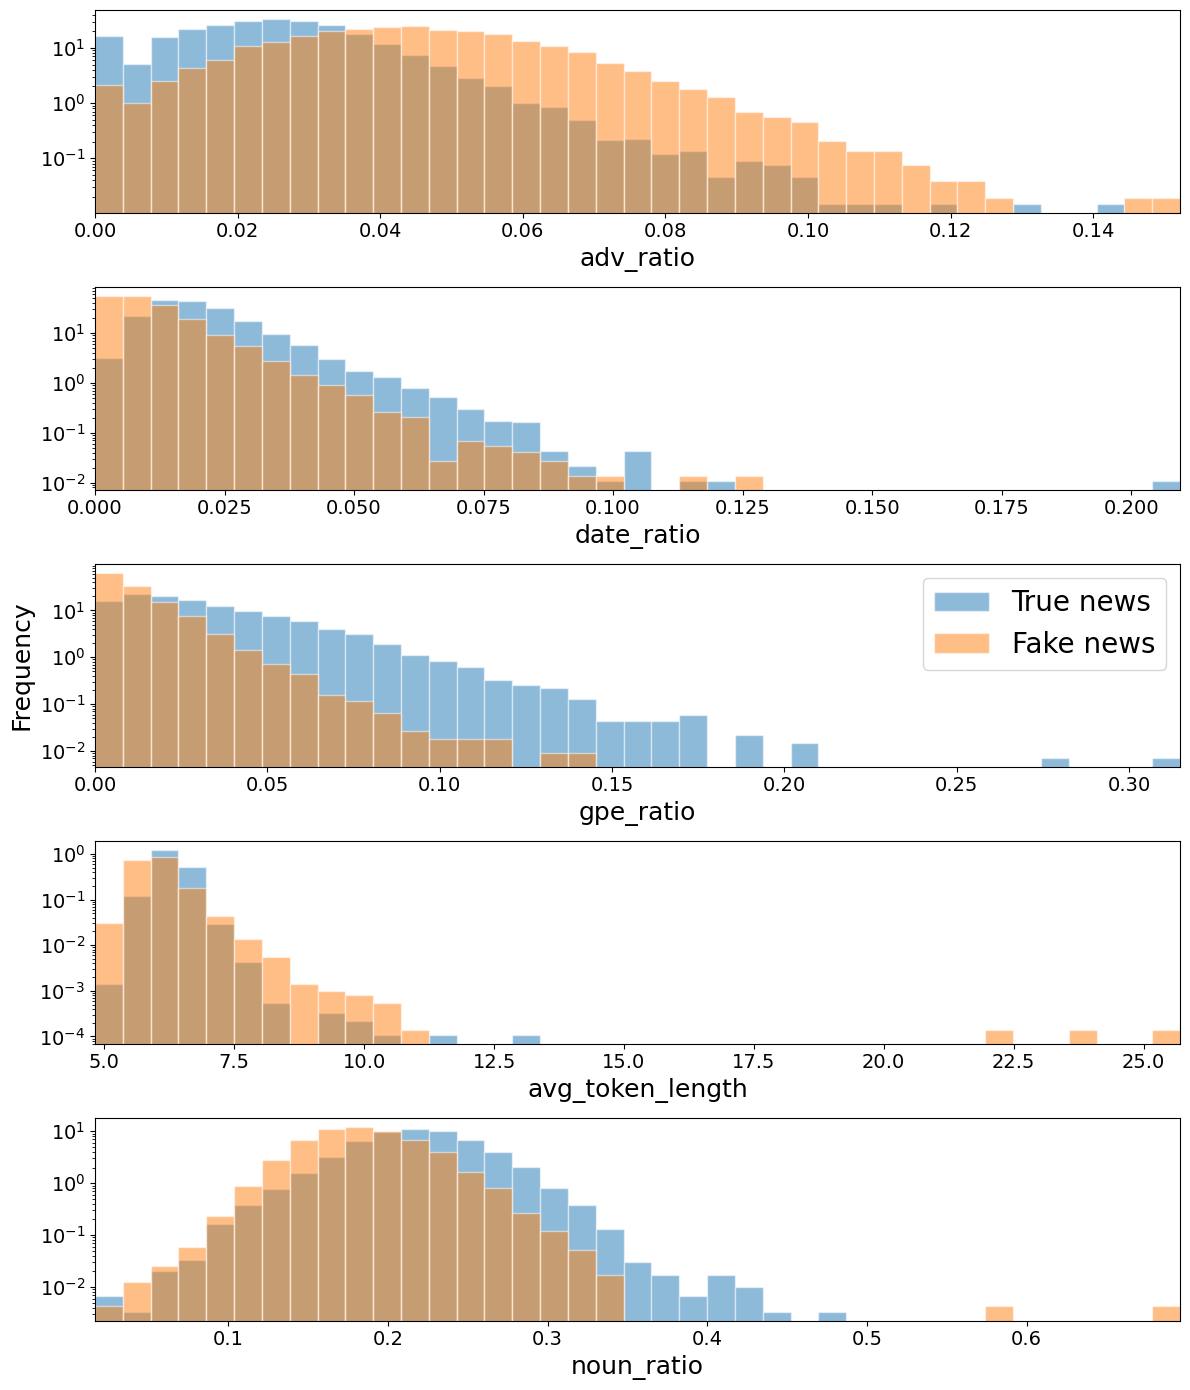

In [30]:
fig, axs = plt.subplots(5, 1, figsize=(12, 14))
for i, feature in enumerate(mis_df[:5]["Feature"]):
    masked_true = train_text_first_features[train_text_first_features["label"] == 0]
    masked_fake = train_text_first_features[train_text_first_features["label"] == 1]
    xmin = min(masked_true[feature].min(), masked_fake[feature].min())
    xmax = max(masked_true[feature].max(), masked_fake[feature].max())
    bins = np.linspace(xmin, xmax, 40)
    
    axs[i].hist(masked_true[feature], bins=bins, edgecolor="w", color="C0", label="True news", density=True, alpha=0.5)
    axs[i].hist(masked_fake[feature], bins=bins, edgecolor="w", color="C1", label="Fake news", density=True, alpha=0.5)
    axs[i].set_xlim((xmin, xmax))
    axs[i].set_yscale("log")
    if i == 2:
        axs[i].legend(fontsize=20)
        axs[i].set_ylabel("Frequency", fontsize=18)
    axs[i].set_xlabel(f"{feature}", fontsize=18)
    axs[i].tick_params(axis="both", labelsize=14)

fig.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
From the histogram above, it stands out that the ratio of adverbs, `adv_ratio`, and the ratio of uppercase words are much more pronounced in fake news compared to true news. The `intj_ratio`, in particular, often signifies a certain intensity or tone that is commonly associated with fake news, where there is a tendency to emphasize or exaggerate certain pieces of information—or even misinformation. This pattern may help the model distinguish between the two types of news based on these linguistic cues.
</div>

### **Heuristic model**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
It’s now time to use a heuristic model to gain a deeper understanding of how our data is organized. To do this, we will use the `HeuristicModel` class (see `heuristic_utilities.py`). Here’s how the heuristic model works:

* **Binning**: Every feature used by the heuristic model is binned, either automatically or manually.
* **Weight of Evidence (WoE)**: For each bin, we compute the WoE and the Information Value (IV). The WoE is the logarithmic ratio between the number of items belonging to a class and the number of items not belonging to that class:
  
  $$ WoE = \log \frac{\%Event}{\%Non Event} $$

  The WoE can be either positive or negative. It defines a score for each bin: if an instance has its feature value within this bin, its score will be the WoE for that bin. The global score for an instance is the sum of the WoEs from its feature values across all bins. The model uses this score to predict the target class. 

  For example, let’s say we have two features and one target. For the first feature, the instance receives a WoE of -1.4, and for the second feature, it receives a WoE of 0.8. This means the first feature suggests the instance belongs to class 0, while the second feature is more common in instances belonging to class 1. If we sum the two WoEs, we get a score of -0.6, so the instance is predicted to belong to class 0.

* **Information Value (IV)**: The Information Value measures the predictive power of a feature for the given binning. It’s computed as:

  $$ IV = \sum (\%Event - \%Non Event) \times WoE $$

  The IV helps us understand the importance of each feature in predicting the target.

This heuristic model provides a simple and intuitive way to explore the data and understand feature relationships without requiring any training. Although it is not designed to be a model for deployment, it can be incredibly useful for data exploration and feature selection. 

Check out the graphs below for visualizations of the model in action.
</div>

In [31]:
ff_model = HeuristicModel()
ff_model.setup_model(train_text_first_features, "label", bins=20)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
We’ve created a heuristic model that, for each feature in the input dataset, performs a 20-interval binning, builds a WoE table for each feature, and creates a protocol (a function made of `if` statements) to estimate model performance on unseen data. 

Before we proceed with evaluating its performance, let's first visualize the Information Value (IV) for each feature to identify the most important ones. Once we've identified the top features, we can dive deeper into how their protocols work and explore how they perform.
</div>

Text(0.5, 0.98, 'Text features Information Value')

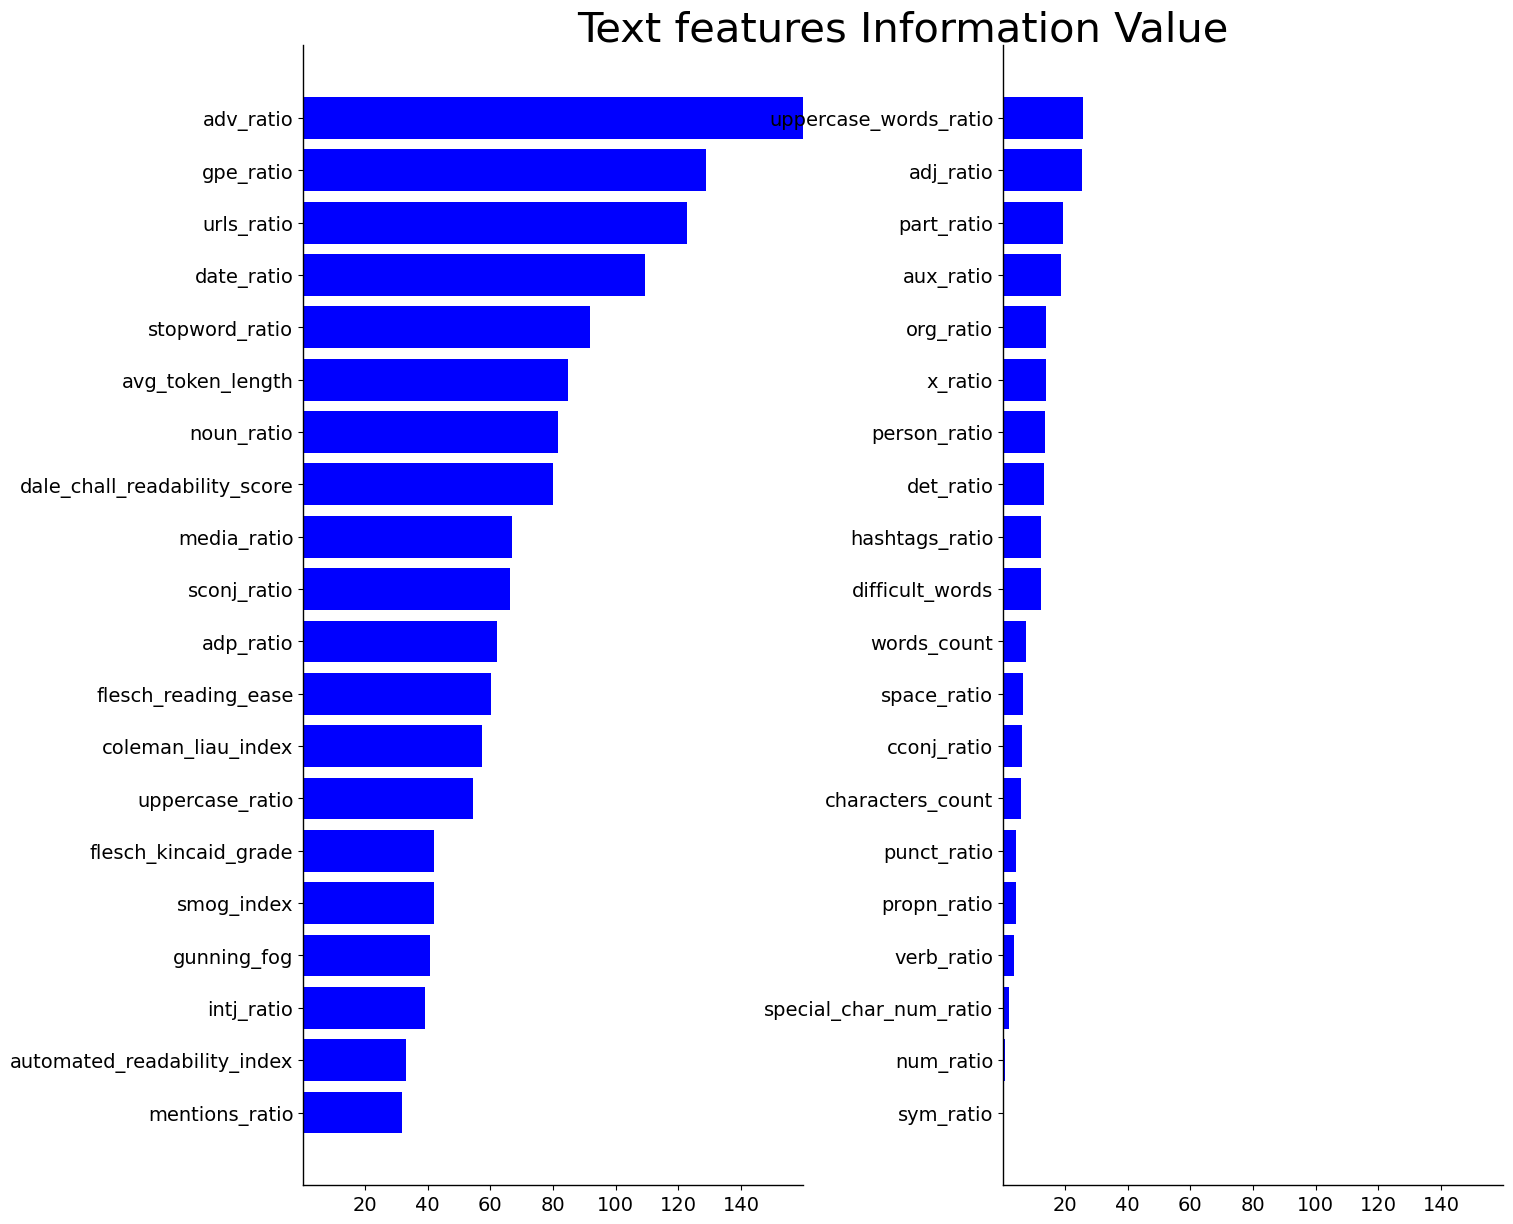

In [32]:
IV_scores_ff = ff_model.get_IV_scores()
IV_ff = pd.DataFrame(list(IV_scores_ff.items()), columns=['Feature', 'IV'])
fig = plt.figure(figsize=(12, 12))
axs = multicolumn_barplot(
    IV_ff, fig, y="Feature", width="IV", tick_fs=14
)
fig.suptitle("Text features Information Value", fontsize=30)

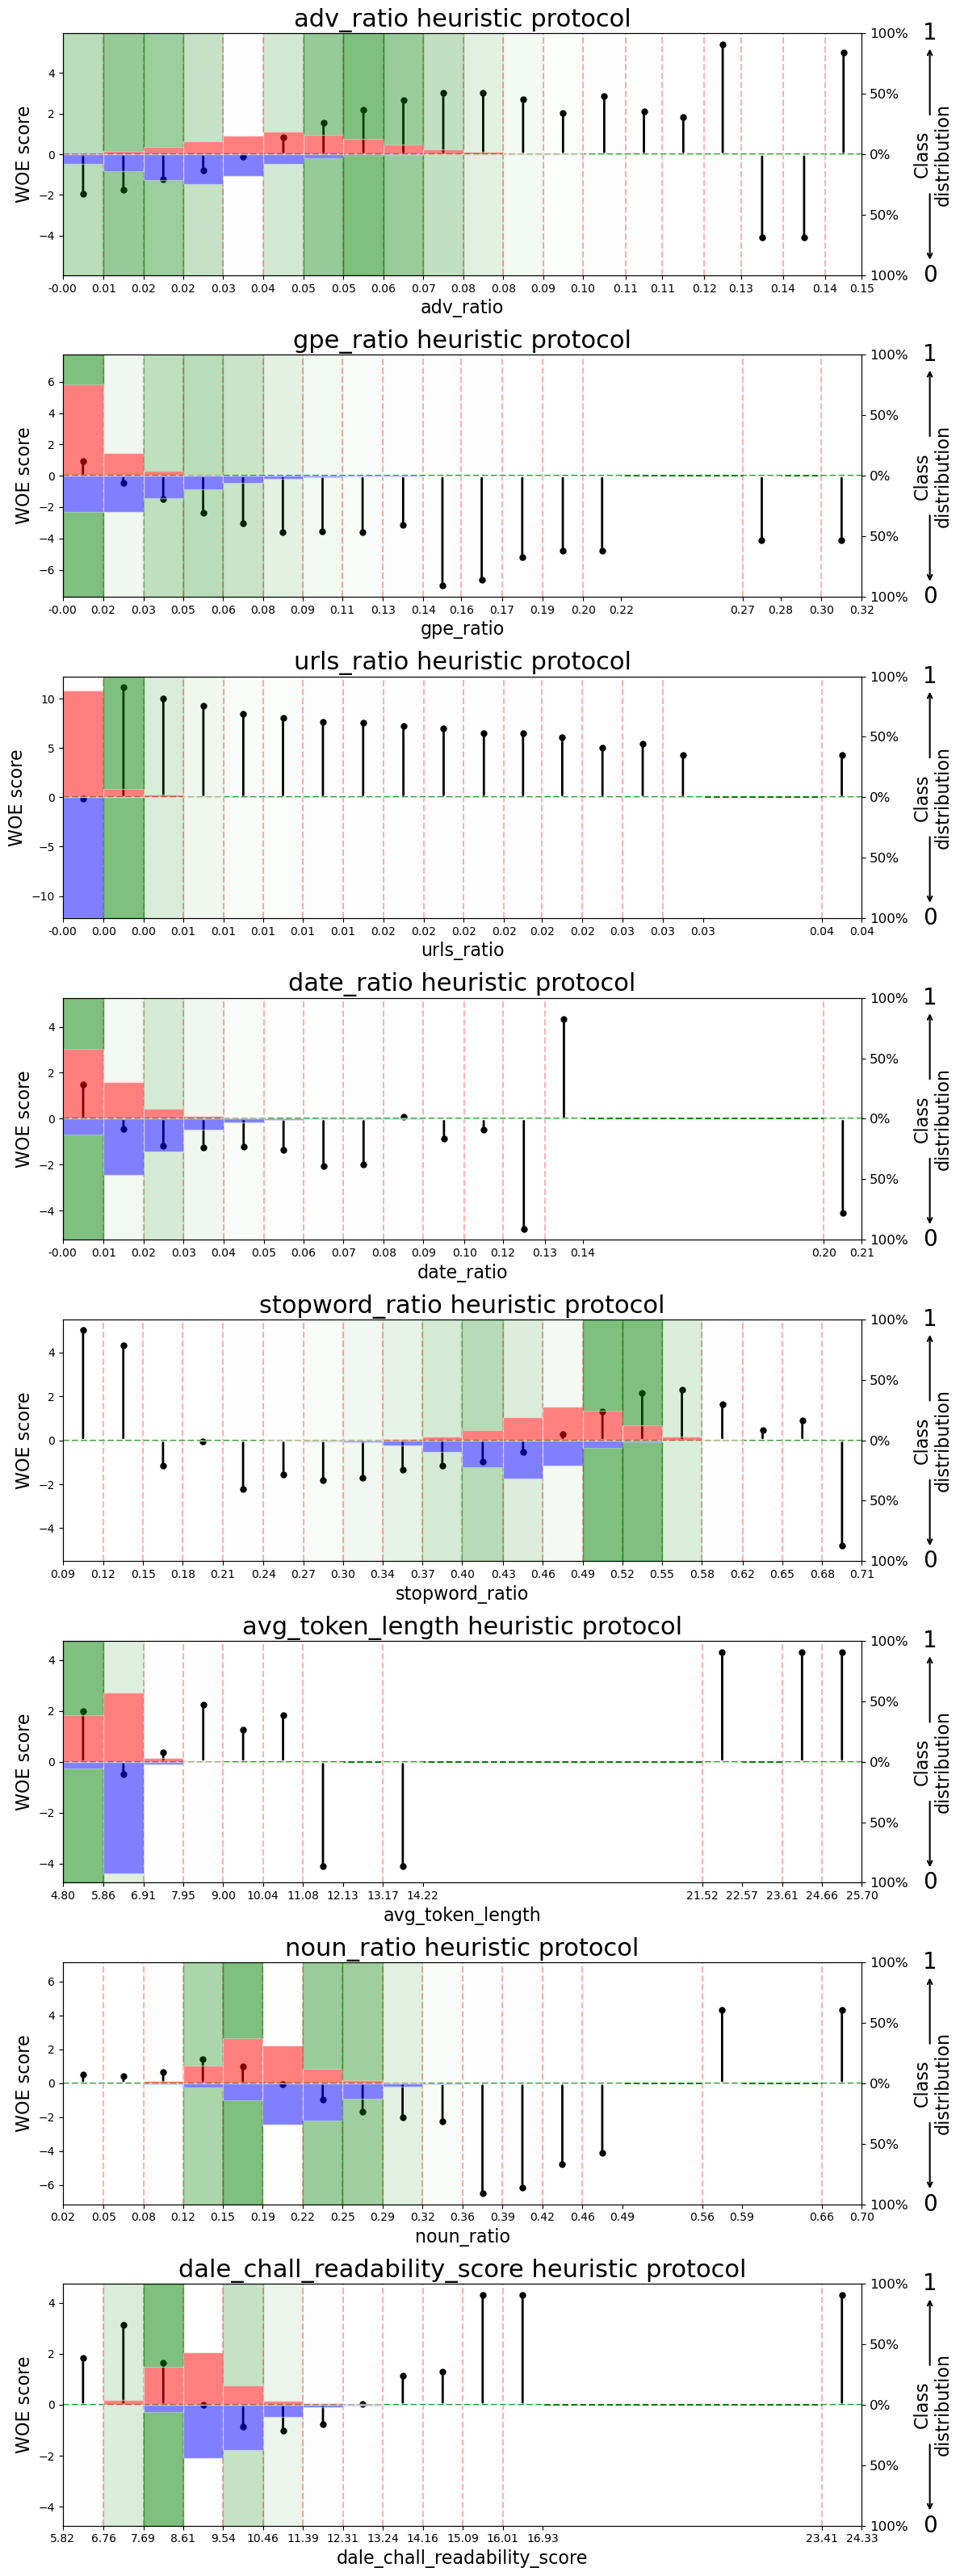

In [33]:
best_ff_features = IV_ff.iloc[:8]["Feature"]
fig, axs = ff_model.plot_protocol(list(best_ff_features))

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

The most important features based on the Information Value (IV) are almost identical to those from Mutual Information, with only a slight difference in order. The top three features are similar, but the ranking shifts a bit. The top features include adverb ratio, uppercase ratio, and GPE ratio, followed by the stopword ratio and the Dale-Chall readability score.

When we look at the protocol graph for each of these features, it helps us understand how the target (fake vs. true news) is distributed differently across these features. It’s important to highlight the green areas, as the more intense the green, the higher the Information Value. This indicates that within these regions, the feature is a better discriminant for the target.

For instance, in the first bins of the `adv_ratio`, the second bin is quite predictive. It shows that the number of instances belonging to class 0 (true news) is significantly higher in this range, and the support is large enough to make it a reliable indicator. In other words, the fake news articles tend to contain more adverbs than the legit news articles.

From the `dale-chall_readability_score`, we can observe that true news is generally more readable than fake news, which makes sense given that true news sources seem to come from established outlets like Reuters, while fake news is often pulled from unformatted sources like Twitter feeds.

Interestingly, we also see a higher `stopword_ratio` in fake news. This could indicate that fake news tends to be less carefully written or more casual, as the higher use of stopwords might be a sign of informal or hurried writing. It’s a potential signal of a lack of professionalism in writing.

These visualizations provide valuable insights into how different features can contribute to distinguishing between true and fake news, and how the target is distributed across various feature values.
</div>

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
One of the main advantages of the heuristic model is that, in addition to helping us understand the relationships between features and the target, it can also make predictions. By applying the protocols generated by the heuristic model to the test set, we can assess how well it performs on unseen data.

Let’s run the heuristic model on the test set and evaluate its performance, checking metrics such as accuracy, precision, recall, and F1 score. This will give us a sense of how well our simple, rule-based approach works and whether there are areas that could be improved.
</div>

In [34]:
ff_scores = ff_model.predict(test_text_first_features, features=best_ff_features, n_jobs=-1)
print(classification_report(test_text_first_features["label"], ff_scores))

Features used for predictions are 
['adv_ratio', 'gpe_ratio', 'avg_token_length', 'noun_ratio', 'dale_chall_readability_score', 'urls_ratio', 'stopword_ratio', 'date_ratio'].
The following features were in the dataset but not in the model: 
['hashtags_ratio', 'characters_count', 'flesch_reading_ease', 'aux_ratio', 'adj_ratio', 'num_ratio', 'coleman_liau_index', 'label', 'text', 'uppercase_words_ratio', 'part_ratio', 'verb_ratio', 'flesch_kincaid_grade', 'special_char_num_ratio', 'cconj_ratio', 'media_ratio', 'difficult_words', 'adp_ratio', 'sconj_ratio', 'space_ratio', 'words_count', 'uppercase_ratio', 'punct_ratio', 'mentions_ratio', 'smog_index', 'automated_readability_index', 'person_ratio', 'x_ratio', 'det_ratio', 'gunning_fog', 'sym_ratio', 'org_ratio', 'propn_ratio', 'intj_ratio']
The following features were in the model but not the dataset: 
[]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      4236
           1       0.85    

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
It’s great and sad to see that the heuristic model performs so well on unseen data, with an F1 score of 0.86 and an accuracy of 0.84, and so by using only 7 features. Usually, heuristic models aren’t typically expected to reach such high performance, so it’s important not to jump to conclusions too quickly. This suggests that there may be some remaining structure or patterns in the dataset that the heuristic model is exploiting and that should be removed if we want our future ML models to generalize well.
</div>

### **TF-IDF**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Before drawing any final conclusions, it’s wise to proceed with another round of feature extraction, this time based on **TF-IDF** (Term Frequency - Inverse Document Frequency). TF-IDF will help capture important keywords and their relative importance across the entire dataset, adding another layer of information to improve our model’s predictive power. The **TF-IDF** extraction is preceeded by a cleaning step during which some characteristic Twitter pattern are removed (see `nltk_clean_text` in `preprocessing_utilities.py`)

We'll start by extracting all possible unigrams TF-IDF features. Then, we will select those with the best univariate predictive power using their p-values from a chi2 test. Once this selection is complete, we'll create a new heuristic model to gather more insights about the data.
</div>

In [35]:
tfidf = TfidfVectorizer(
    strip_accents='unicode',
    preprocessor=nltk_clean_text,
    lowercase=False,
    ngram_range=(1, 1)
)

tfidf_train_matrix = tfidf.fit_transform(train_set["text"])
tfidf_test_matrix = tfidf.transform(test_set["text"])
_, p = chi2(X=tfidf_train_matrix, y=train_set["label"])
selected_indices = np.argpartition(p, 100)[:100]
selected_feature_names = tfidf.get_feature_names_out()[selected_indices]

tfidf_train_df = get_df_from_sparse(tfidf_train_matrix,
                                    train_set,
                                    "label",
                                    selected_feature_names, 
                                    selected_indices, 
                                    )
tfidf_test_df = get_df_from_sparse(tfidf_test_matrix,
                                    test_set,
                                    "label",
                                    selected_feature_names, 
                                    selected_indices
                                    )

In [36]:
tfidf_model = HeuristicModel()
tfidf_model.setup_model(tfidf_train_df, "label", bins=20)

Text(0.5, 0.98, 'Text features Information Value')

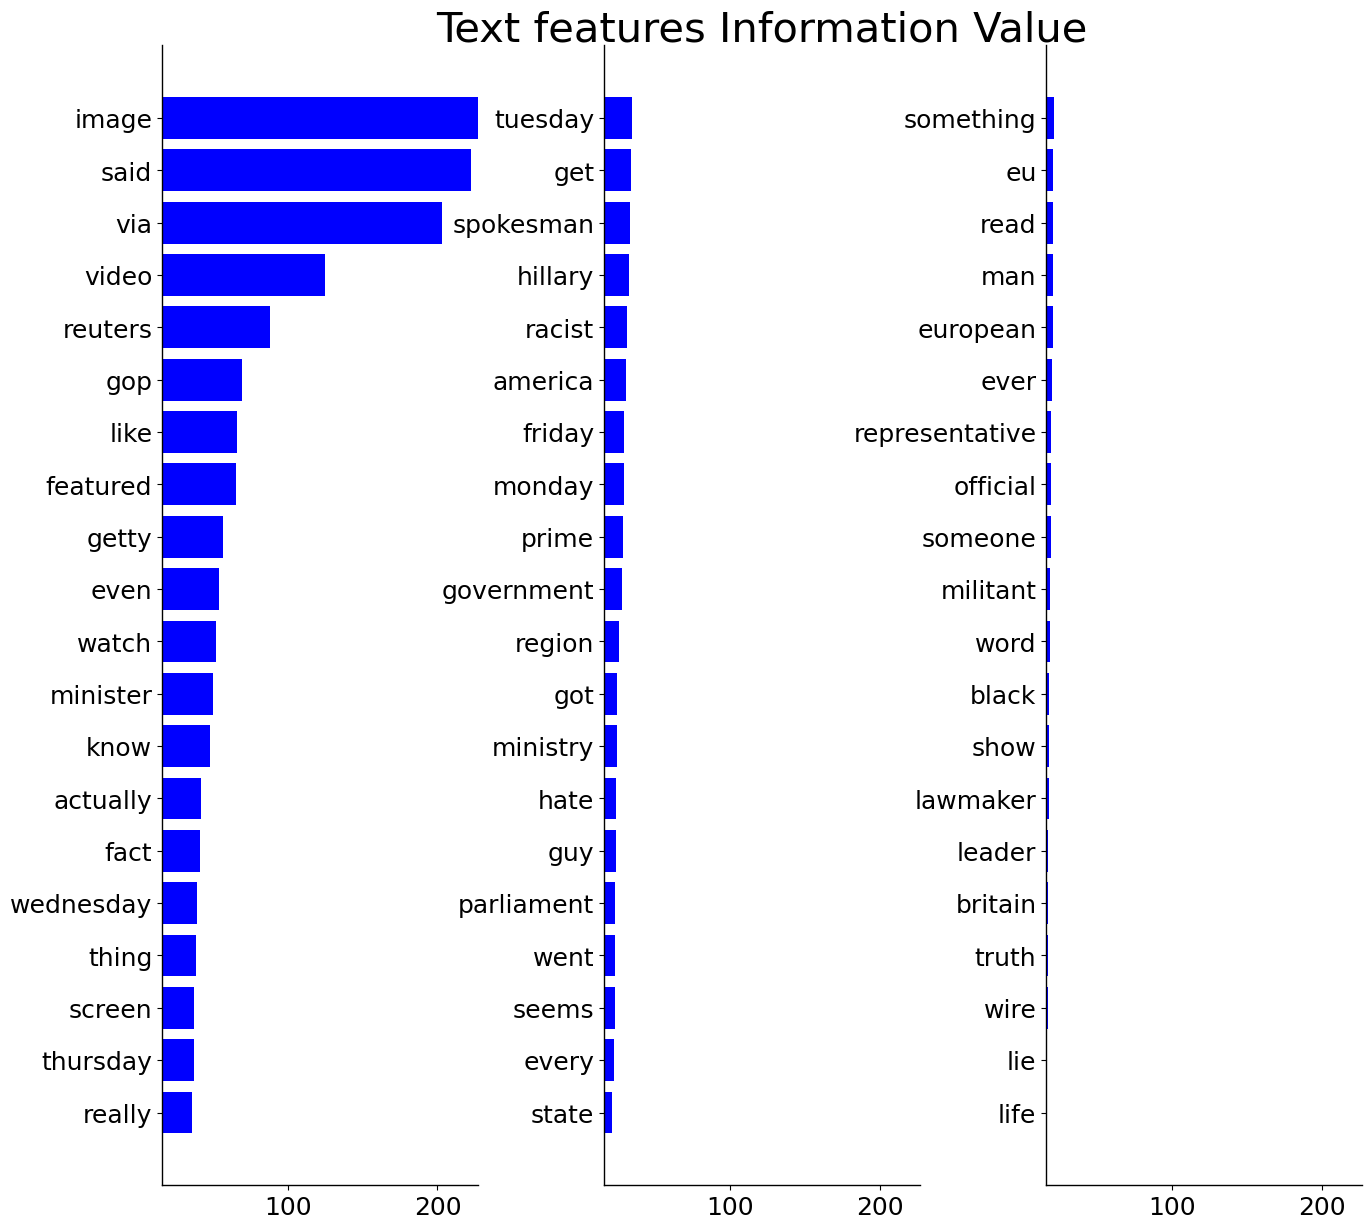

In [37]:
IV_scores_tfidf = tfidf_model.get_IV_scores()
IV_tfidf = pd.DataFrame(list(IV_scores_tfidf.items()), columns=['Feature', 'IV'])
fig = plt.figure(figsize=(12, 12))
axs = multicolumn_barplot(
    IV_tfidf[:60], fig, y="Feature", width="IV", tick_fs=18, num_col=3
)
fig.suptitle("Text features Information Value", fontsize=30)

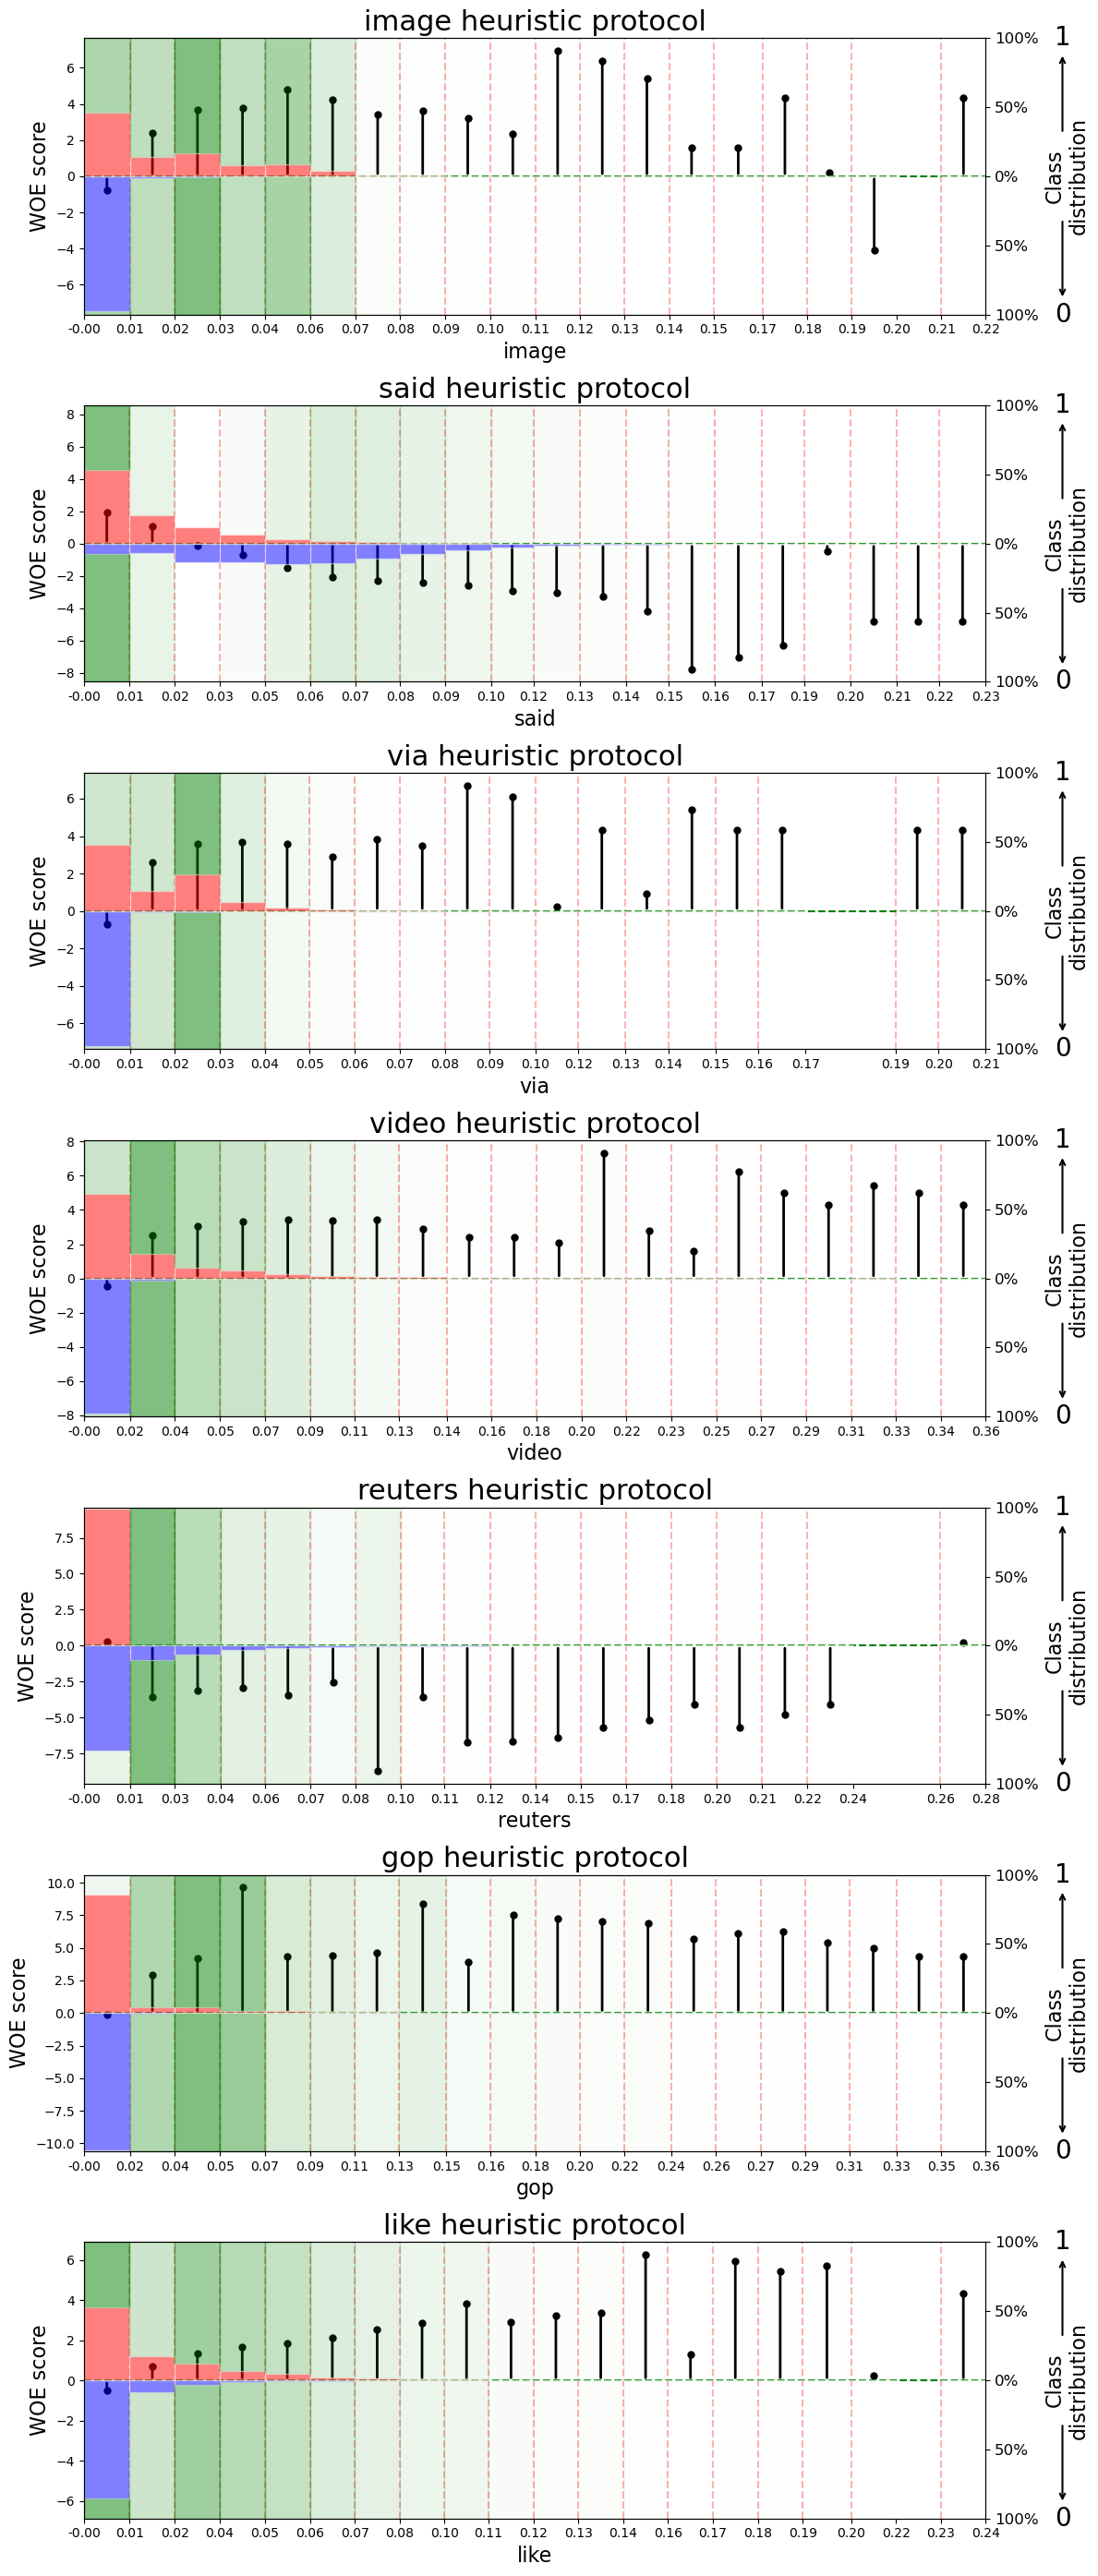

In [38]:
best_tfidf_features = IV_tfidf.iloc[:7]["Feature"]
fig, axs = tfidf_model.plot_protocol(list(best_tfidf_features))

In [39]:
tfidf_scores = tfidf_model.predict(tfidf_test_df, features=best_tfidf_features, n_jobs=-1)
print(classification_report(tfidf_test_df["label"], tfidf_scores))

Features used for predictions are 
['gop', 'via', 'video', 'said', 'reuters', 'image', 'like'].
The following features were in the dataset but not in the model: 
['even', 'united', 'guy', 'cop', 'featured', 'european', 'man', 'committee', 'kid', 'parliament', 'gun', 'spokesman', 'watch', 'rohingya', 'south', 'un', 'tillerson', 'trade', 'love', 'nov', 'read', 'state', 'lie', 'fact', 'coalition', 'know', 'referendum', 'monday', 'fox', 'hate', 'really', 'kurdish', 'hillary', 'leader', 'got', 'military', 'thursday', 'someone', 'wednesday', 'went', 'america', 'mr', 'black', 'government', 'woman', 'lawmaker', 'region', 'britain', 'macron', 'missile', 'official', 'turkey', 'minister', 'senate', 'nuclear', 'truth', 'trump', 'myanmar', 'brexit', 'ministry', 'wire', 'iran', 'militant', 'word', 'screen', 'representative', 'label', 'korean', 'china', 'house', 'tax', 'prime', 'something', 'ever', 'life', 'get', 'show', 'korea', 'thing', 'north', 'merkel', 'actually', 'eu', 'getty', 'tuesday', 'oppo

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Once again, we've been able to create a quite powerful predictor, with an F1-score of 0.92 and an accuracy of 0.91, thanks to this heuristic model and, again, by using only the top seven IV features. It is important to notice that the top features are not words of significant semantic meaning. However, they can still relate to the way these news articles were written. For example, the word `image` might be overrepresented in fake news due to its Twitter-related nature, and this despite our preliminary cleaning. The same goes for the words `like`, `via` or `video`.  It could also explain why the `adv_ratio` feature had so much predictive power in the previous heuristic model, as `like` or `via` are adverbs. For the word `reuters` it clearly seems that we did not clean the location line as well as we thought.

Also, we find that `GOP`, which stands for `Grand Old Party` (i.e., the `Republican Party`), is an acronym for an organization. As we've observed, the number of named organizations is a powerful predictor.

On the other hand, we see that the word `said` is more frequent in true news, as they are likely more professional and therefore cite their sources. The high frequency of the word `get` in fake news could also further confirm the poverty of vocabulary used in such articles or for it's often social network related origin. 

With less importance, we detect some American politician names such as `hillary` or `trump`. Of course, we've already seen that our data is centered on American politics and was collected around the Donald Trump election, so it is normal that he and his opponent are often quoted in the news.
</div>

### **Final heuristic model**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We can even merge the two previous heuristic models into a larger one that will consider every feature. Let's see how such a model could perform.
</div>

In [40]:
all_features_model = ff_model.merge(tfidf_model)
all_features_df = pd.concat([test_text_first_features, tfidf_test_df], axis=1)
all_features_df = all_features_df.loc[:, ~all_features_df.columns.duplicated()]

In [41]:
all_features_scores = all_features_model.predict(all_features_df, n_jobs=-1)
print(classification_report(all_features_df["label"], all_features_scores))

Features used for predictions are 
['even', 'united', 'hashtags_ratio', 'flesch_reading_ease', 'committee', 'coleman_liau_index', 'reuters', 'like', 'via', 'rohingya', 'south', 'nov', 'read', 'state', 'lie', 'fact', 'coalition', 'know', 'referendum', 'monday', 'really', 'kurdish', 'hillary', 'leader', 'got', 'military', 'uppercase_ratio', 'wednesday', 'someone', 'mentions_ratio', 'black', 'smog_index', 'government', 'woman', 'lawmaker', 'missile', 'official', 'sym_ratio', 'video', 'senate', 'dale_chall_readability_score', 'truth', 'date_ratio', 'myanmar', 'intj_ratio', 'gop', 'gpe_ratio', 'adj_ratio', 'korean', 'uppercase_words_ratio', 'house', 'tax', 'cconj_ratio', 'something', 'ever', 'media_ratio', 'life', 'difficult_words', 'adp_ratio', 'north', 'merkel', 'eu', 'getty', 'avg_token_length', 'automated_readability_index', 'tuesday', 'opposition', 'person_ratio', 'sanction', 'x_ratio', 'org_ratio', 'friday', 'foreign', 'propn_ratio', 'guy', 'cop', 'featured', 'adv_ratio', 'european', 

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The performance of the merged heuristic model has not improved significantly, despite the quantity of features we've added. This indicates that predictability is highly concentrated around a few features, which we've identified using mutual information or information value techniques.
</div>

## **Strategy for a more generalizable model**

### **Patterns with high predictive power**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
It becomes obvious that the way our datasets were collected differed immensely between the true and fake news, making it very easy to distinguish between the two as demonstrated by the performance of our heuristic models. Sadly, it also means that our model will generalize very poorly. Let's make sure we understand correctly why some patterns occur so much more often in fake news compared to true news and vice versa. We'll extract the most common n-grams containing these words and think about what we should do with them. What we would expect is to make our heuristic model's predictive power worse, until we reach a reasonable score for it. We'll exemplify this by examining the words `said`, `image`, `like`, and `reuters`.
</div>

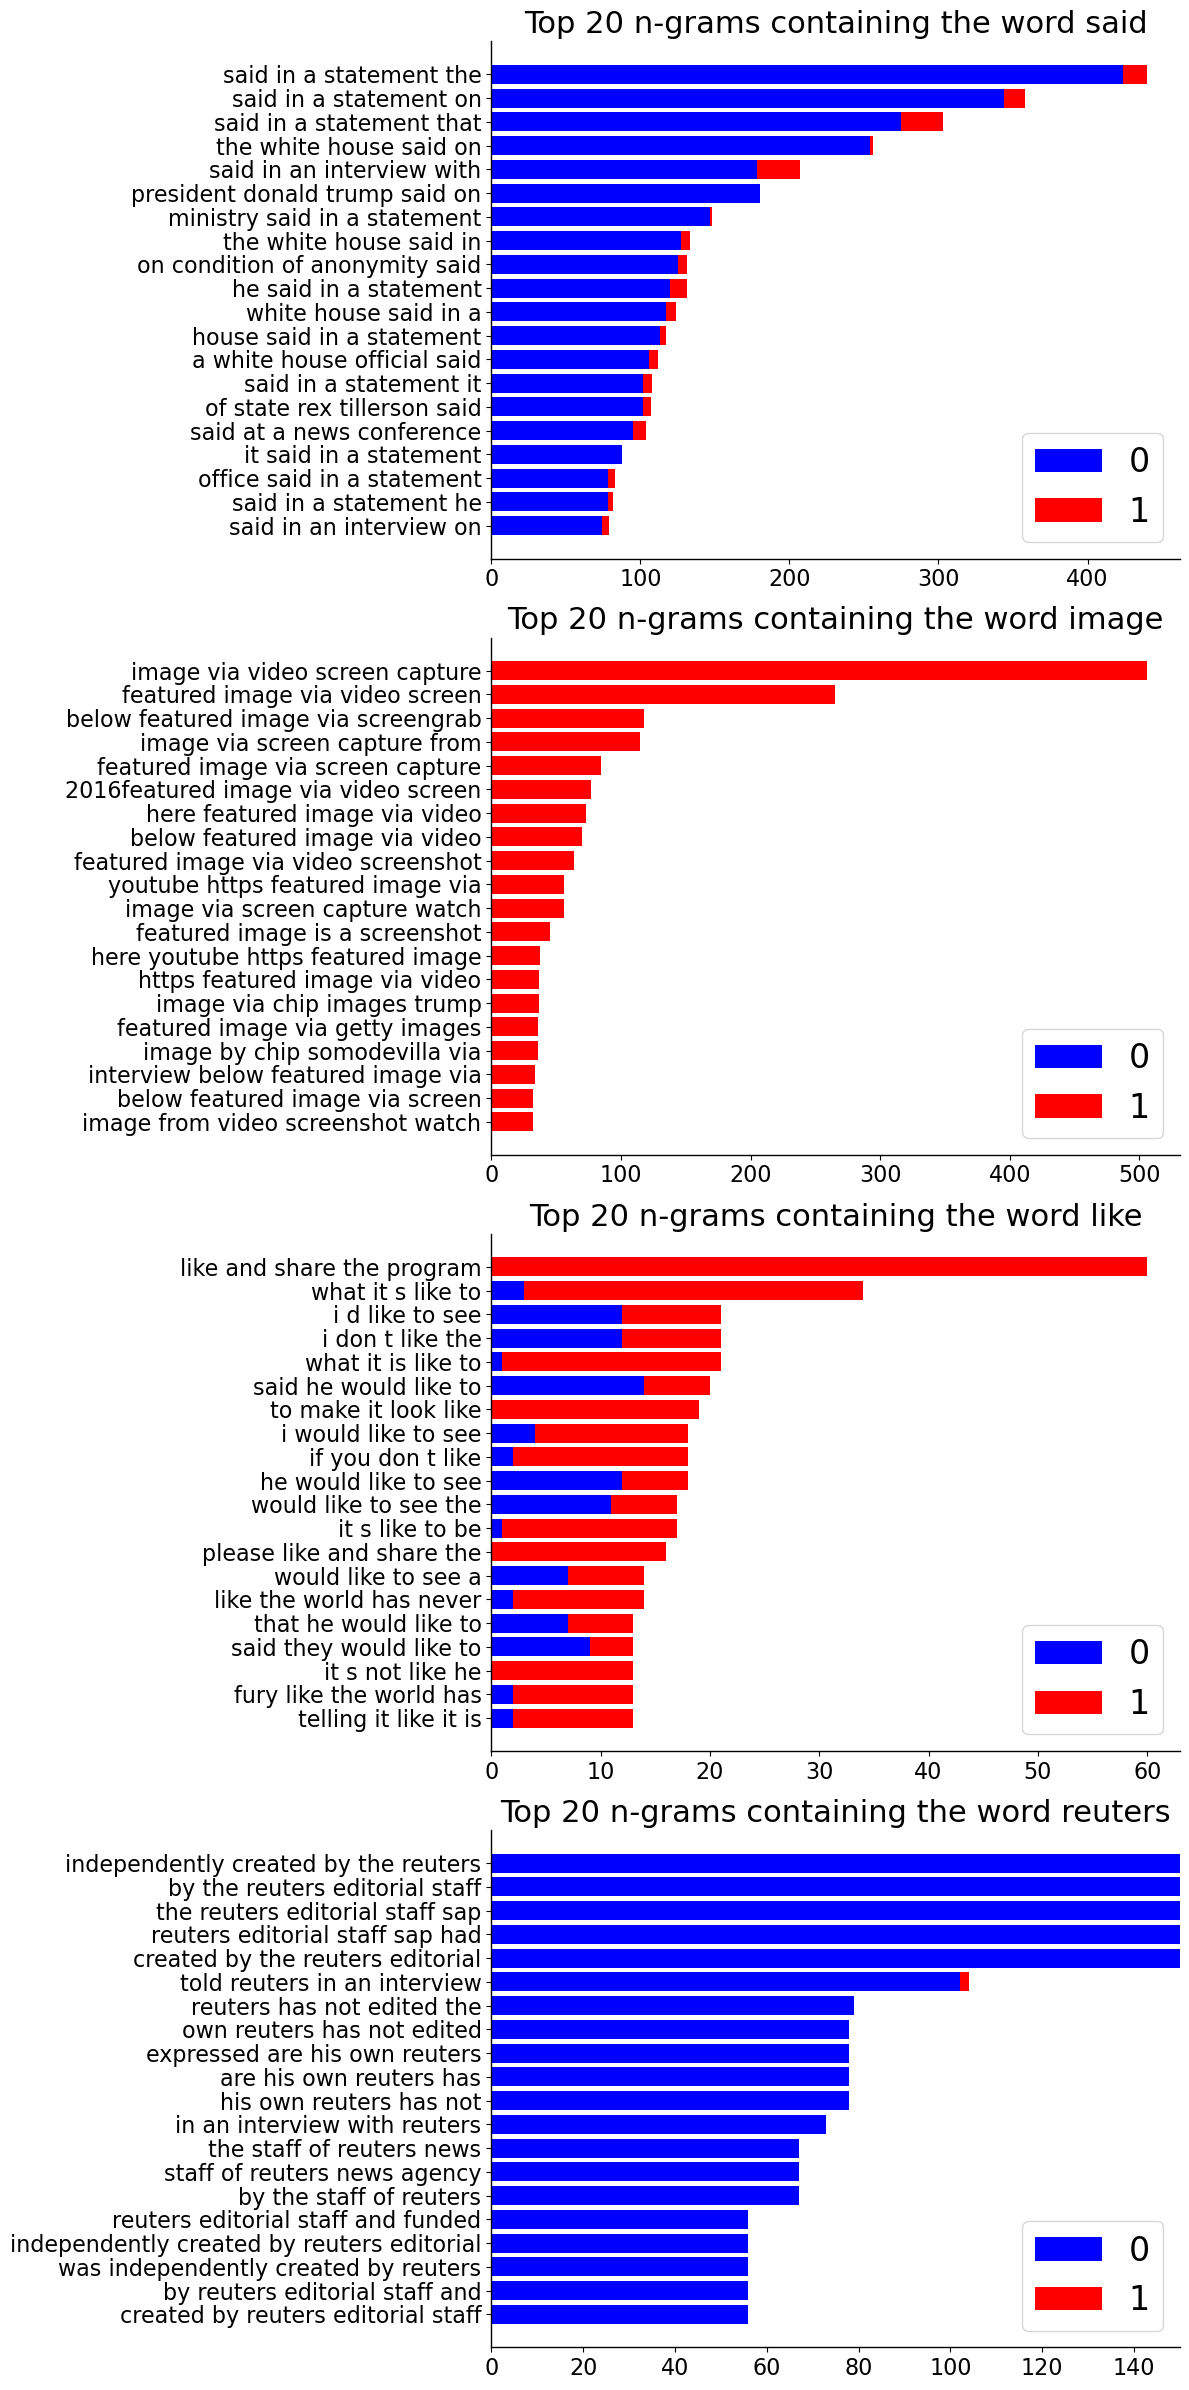

In [42]:
words_to_analyze = ["said", "image", "like", "reuters"]
fig, axs = plt.subplots(len(words_to_analyze), 1, figsize=(12, 6*len(words_to_analyze)))
for i, word in enumerate(words_to_analyze):
    word_ngrams = extract_ngrams(train_set, word=word, top_k=20)   
    _, _ = plot_ngram_distribution(word_ngrams, ax=axs[i])
    axs[i].set_title(f"Top 20 n-grams containing the word {word}", fontsize=22)
fig.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

If we analyze the graphs above, we can see that the words we've detected using the heuristic model are part of n-grams that are almost exclusively present in only one of the two classes, often in contexts that are irrelevant to the news topics but are rather part of editorial templates. For example, it is obvious that a word like `image` predominating in fake news reflects the social network nature of most fake news in our dataset. Conversely, `reuters` is a clear trigger for true news since most of the true news articles in the dataset were collected from Reuters' website. If we want our future Machine Learning model to generalize to any kind of news format, it will be necessary to remove the words that would clearly indicate where the news was collected, irrespective of news content.

To that end, we will thoroughly clean our training set and remove such words but also anonymize the personalities we've found in the text using spaCy, so that if a personality appears more than once in the same text, it will be labeled as `person83gdav8` throughout that text but differently in another. We will do the same for organization names, dates, etc. This way our training data will focus less on specific personality names, organization/country names, and dates. The cleaning will include removing all Twitter or other media-related patterns, retaining only alphanumeric characters, and lemmatizing each piece of text but also removing words that we've identified.
</div>

### **Anonymization and cleaning**

In [43]:
words_to_remove = ["image", "say", "said", "via", "video", "reuters", "like", "featured", "feature", "capture", "isn",
                   "watch", "getty", "even", "actually", "really", "screenshot", "screen", "wasn", "president",
                   "trump", "go", "get", "don", "know", "thing", "think", "tweet", "tweeter", "ll"
                   "facebook", "youtube", "happen", "seek", "let", "tweet", "trade", "mr", "republican", "republicans",
                   "minister", "fact", "government", "official", "claim", "come", "hillary"
                   "didn", "ve", "spokesman", "s", "t", "word", "american", "americans", "didn"]

In [44]:
cleaned_train_set = parallel_process(train_set, 
                                     clean_final_text_batch_spacy, 
                                     num_workers=NUM_WORKERS, 
                                     nlp=nlp, 
                                     batch_size=BATCH_SIZE,
                                     words_to_remove=words_to_remove)

/home/czank/miniconda3/envs/dl_capstone/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|███████████████████████████████████████████████████████████████| 20/20 [03:27<00:00, 10.37s/it]


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Let's compare a news article before and after it has been processed.
</div>

In [53]:
train_set["text"].loc[10340]

'Former Republican presidential candidate Ben Carson, who dropped his bid last week, plans to endorse front-runner Donald Trump on Friday morning, the Washington Post reported on Thursday, citing two people familiar with his thinking. The retired neurosurgeon agreed to the endorsement at a meeting with Trump at the billionaire’s Mar-a-Lago luxury club in Florida, the people said on condition of anonymity, according to the newspaper.  (Reporting by Eric Walsh; Editing by Chris Reese) This article was funded in part by SAP. It was independently created by the Reuters editorial staff. SAP had no editorial involvement in its creation or production. Former Republican presidential hopeful Carson to endorse Trump: Washington Post'

In [54]:
cleaned_train_set["text"].loc[10340]

'presidential candidate person28a462 drop bid datecdd284 plan endorse runner person7b90dd date6fe5db morning org462795 report date994ded cite people familiar thinking retired neurosurgeon agree endorsement meeting org2c3fd0 billionaireperson3cf473 lago luxury club gpee8e8ab people condition anonymity accord newspaper report person38eeb8 editing personf4e546 article fund org2eec57 independently create orgc282bf editorial staff org2eec57 editorial involvement creation production presidential hopeful person219f62 endorse org2c3fd0 org072491'

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The result is as expected. Nonetheless, a question: Why anonymize the persons, organizations, etc., and not just remove them? We have been trying to create a very general framework. The number of persons or organizations quoted in the text could be interesting features, also the maximum number of times the same person was cited in a text. Additionally, it might be interesting when training a transformer-based model as we could state that tokens following certain patterns, such as person, would be labeled specifically.
</div>

In [47]:
tfidf_cleaned = TfidfVectorizer(
    strip_accents='unicode',
    max_features=400,
    lowercase=False,
    ngram_range=(1, 1)
)

tfidf_cleaned_train_matrix = tfidf_cleaned.fit_transform(cleaned_train_set["text"])
tfidf_cleaned_test_matrix = tfidf_cleaned.transform(test_set["text"])

tfidf_cleaned_train_df = get_df_from_sparse(tfidf_cleaned_train_matrix,
                                    cleaned_train_set,
                                    "label",
                                    tfidf_cleaned.get_feature_names_out(), 
                                    )

tfidf_cleaned_test_df = get_df_from_sparse(tfidf_cleaned_test_matrix, 
                                    test_set,
                                    "label",
                                    tfidf_cleaned.get_feature_names_out(),
                                    )

In [48]:
tfidf_model_cleaned = HeuristicModel()
tfidf_model_cleaned.setup_model(tfidf_cleaned_train_df, "label", bins=20)

Text(0.5, 0.98, 'Text features Information Value')

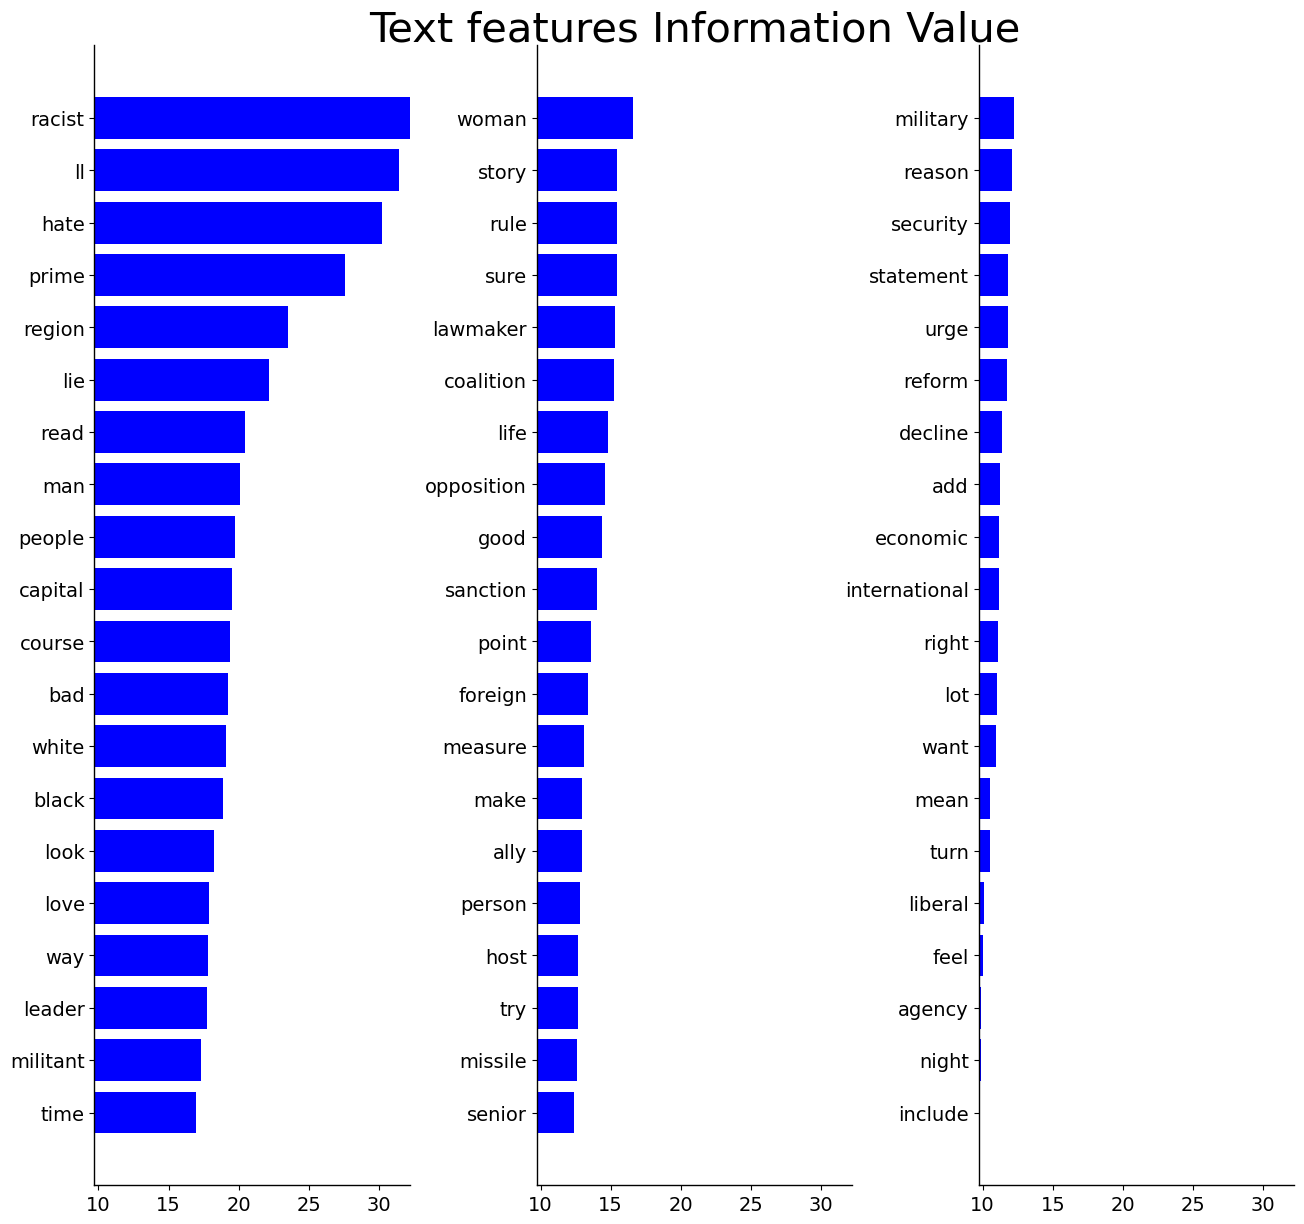

In [49]:
IV_scores_tfidf_cleaned = tfidf_model_cleaned.get_IV_scores()
IV_tfidf_cleaned = pd.DataFrame(list(IV_scores_tfidf_cleaned.items()), columns=['Feature', 'IV'])
fig = plt.figure(figsize=(12, 12))
axs = multicolumn_barplot(
    IV_tfidf_cleaned[:60], fig, y="Feature", width="IV", tick_fs=14, num_col=3
)
fig.suptitle("Text features Information Value", fontsize=30)

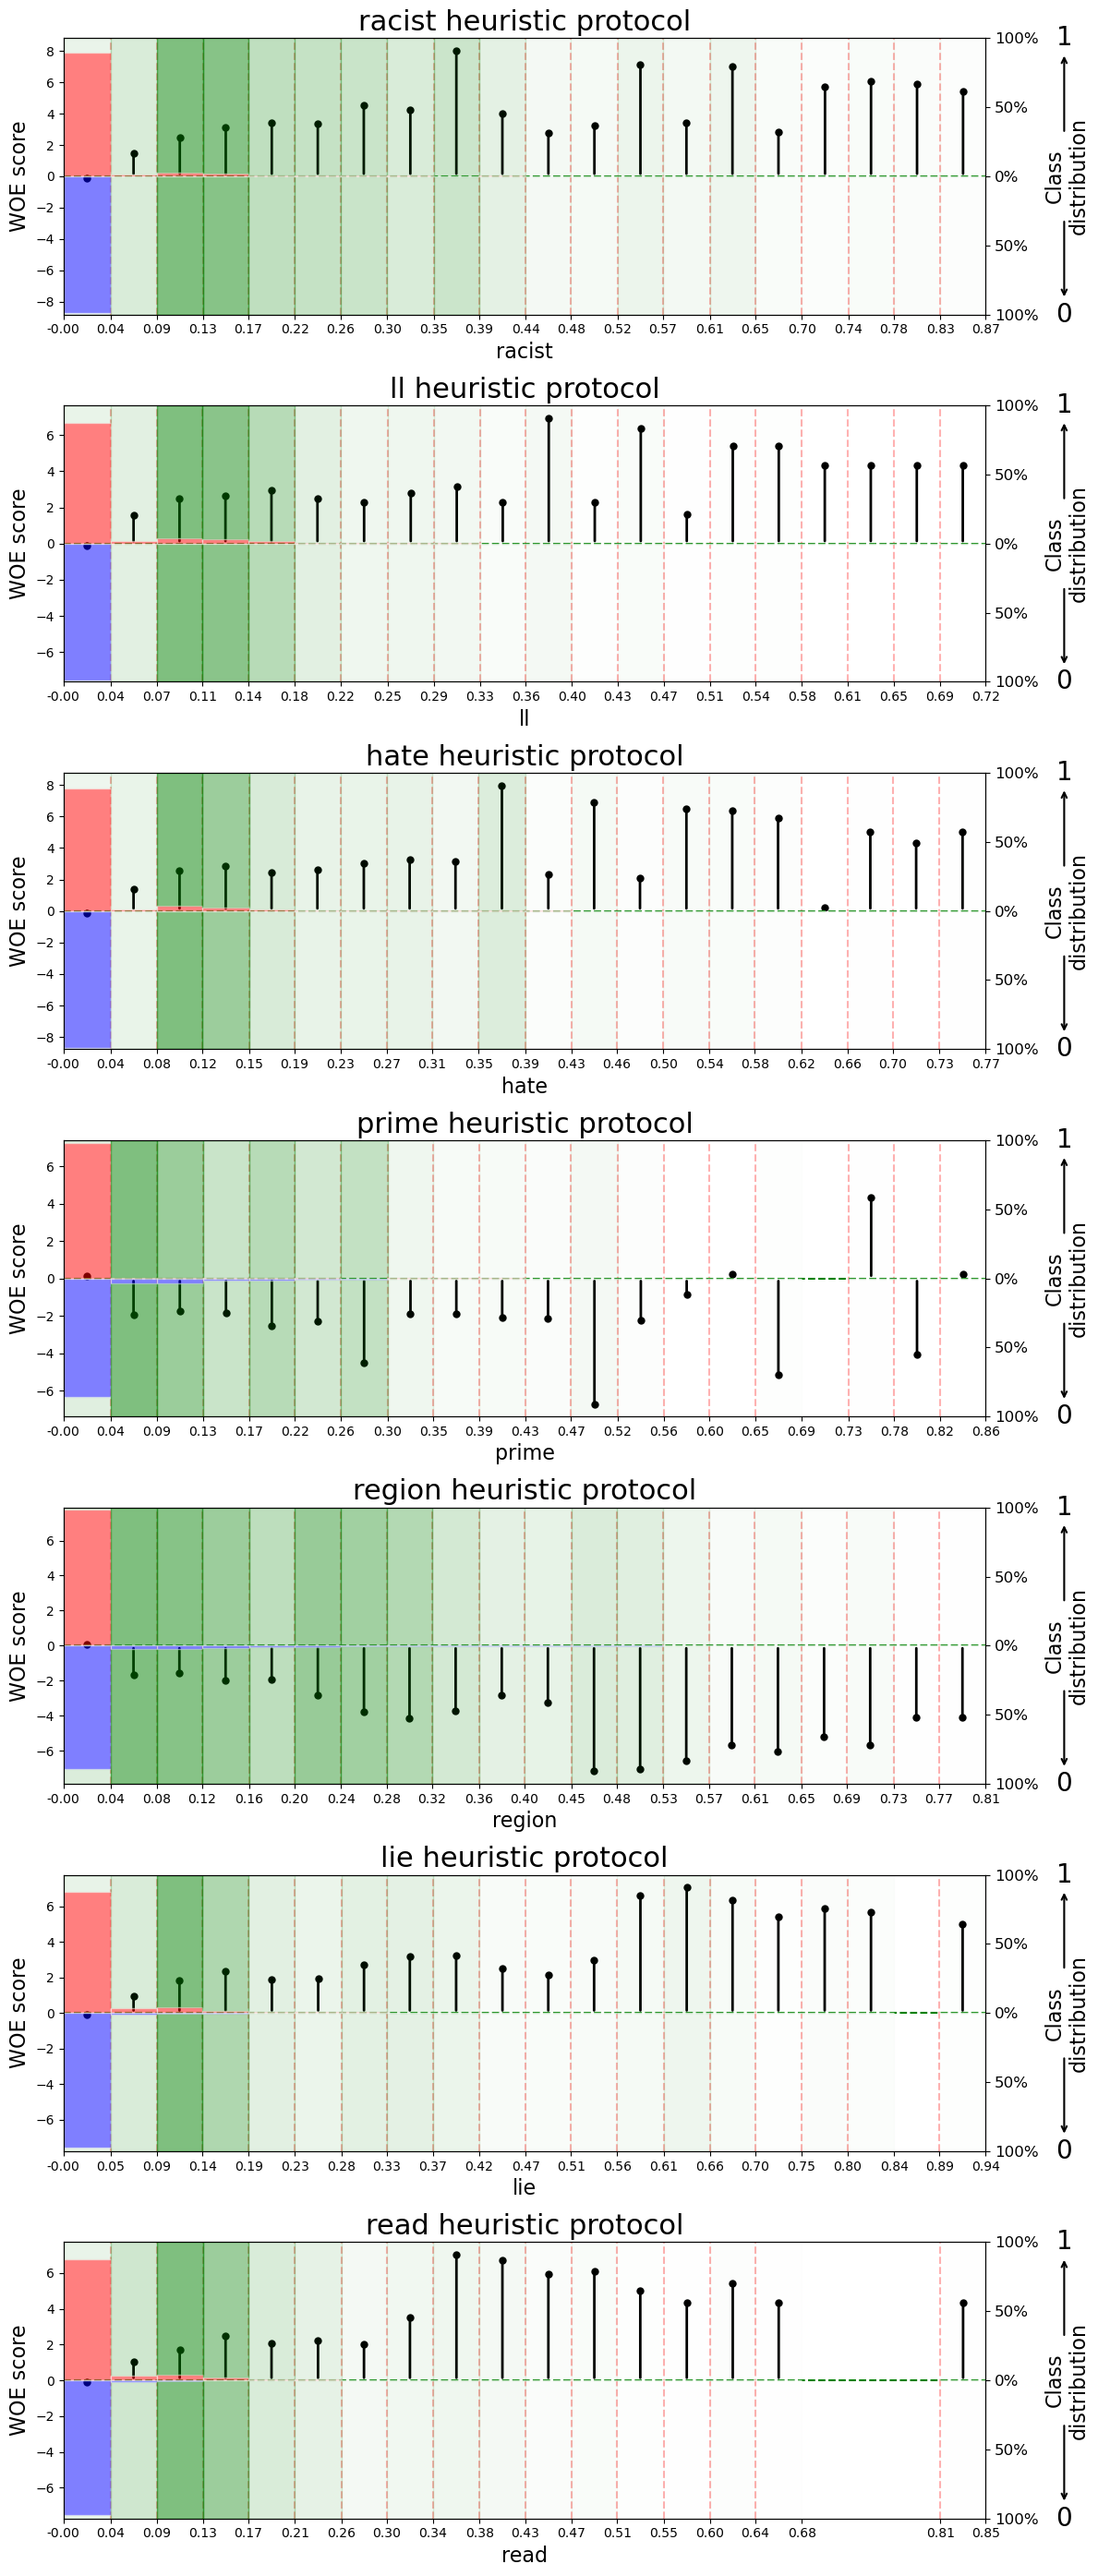

In [50]:
best_tfidf_cleaned_features = IV_tfidf_cleaned.iloc[:7]["Feature"]
fig, axs = tfidf_model_cleaned.plot_protocol(list(best_tfidf_cleaned_features))

In [51]:
tfidf_cleaned_scores = tfidf_model_cleaned.predict(tfidf_cleaned_test_df, n_jobs=-1)
print(classification_report(tfidf_cleaned_test_df["label"], tfidf_cleaned_scores))

Features used for predictions are 
['matter', 'information', 'anti', 'committee', 'time', 'far', 'reform', 'officer', 'south', 'legal', 'policy', 'state', 'big', 'defend', 'look', 'away', 'death', 'lawmaker', 'individual', 'll', 'senior', 'market', 'history', 'area', 'terrorist', 'hand', 'secretary', 'justice', 'write', 'possible', 'lot', 'money', 'allow', 'way', 'illegal', 'people', 'lead', 'appear', 'point', 'sanction', 'work', 'world', 'pay', 'help', 'border', 'authority', 'power', 'foreign', 'back', 'company', 'hold', 'reason', 'immigration', 'billion', 'country', 'nominee', 'home', 'move', 'bring', 'street', 'serve', 'case', 'good', 'deny', 'describe', 'head', 'race', 'violence', 'need', 'involve', 'face', 'problem', 'attack', 'economic', 'mean', 'militant', 'lawyer', 'important', 'recent', 'criticize', 'democratic', 'staff', 'announce', 'city', 'early', 'private', 'plan', 'report', 'great', 'cost', 'senator', 'source', 'citizen', 'instead', 'late', 'speech', 'office', 'confirm', 

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

By cleaning and anonymizing our training set, we've been able to reduce the predictive power of our heuristic model by quite a lot. We can now be more confident that the future ML models we would train on such a set would generalize better and not simply rely on detecting patterns coming from the different nature of the fake and true news collection process. Nonetheless, there is still room to further "strengthen" our training set. What if we could correctly rewrite some of the fake news in a more professional way? Of course, we should not do this on the entire dataset as we need to maintain a dataset that is also representative of typical social media fake news. Let's first identify in both the training and test datasets some fake news that we could try to rewrite in a more professional or Reuters-like way, and conversely some true news that we could rewrite in a more social network style. All of this will take place in the `rewriting.ipynb` notebook.
</div>

## **Conclusion**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
    
In this notebook we've:
* explored our data in depth and made some preliminary cleaning by removing every item that would not contribute to the future training of our ML or DL models
* found that our data was both clustered in time and topics, since the immense majority of the articles are treating news from an American point of view, and were extracted during a time window which covers the rise of Donald Trump to the presidency and his early presidency
* built a heuristic model class to help us further identify features too characteristic of one class or another that would have prevented our model from generalizing
* found a strategy, with the help of our heuristic model, to reduce the inherent bias that came from the data collection. This strategy will consist of some special preprocessing of our training data before inputting it into our future ML model
</div>